In [1]:
import json, os, math, sys, re, random
import numpy as np
from collections import defaultdict, Counter
from tqdm import tqdm, trange
from pprint import pprint
import matplotlib.pyplot as plt 
import matplotlib
import pandas as pd

In [2]:
task = "selective_modular_4items"

if "samesymbol" in task:
    one = lambda: 'a'
elif "diffsymbol" in task:
    one = lambda: random.choice('abcdefghijklmnopqrstuvwxyz')
else:
    pass

## Vanilla

In [3]:
count_range = range(1, 51)
count_range_ood = range(51, 100)
addon_range = range(1, 101)
count_prob = [1] * len(count_range)
count_ood_prob = [math.sqrt((100-x)/50) for x in count_range_ood]
addon_prob = [1] * len(addon_range)
num_val = 300
num_train = 1000000
num_data = num_train + num_val

In [21]:
# create training set
input_stats = np.zeros((len(count_range), len(addon_range)))
output_stats = np.zeros(len(addon_range))

for i in trange(num_train):
    count = random.choices(count_range, count_prob)[0]
    addon = random.choices(addon_range[:-count], addon_prob[:-count])[0]
    input_stats[count-1, addon-1] += 1
    #output_stats[addon+count-1] += 1

# create val set
val_data = []
input_stats_val = np.zeros_like(input_stats)
numr, numc = input_stats.shape
# for i in random.sample(list(np.flatnonzero(input_stats)), num_val):
#     r, c = i//numc, i%numc
with open(f"../data/rasp_primitives/counting_{task}/val.txt", "r") as f:
    lines = f.readlines()
    for l in lines:
        x, y = json.loads(l)
        count, addon = int(y[-2]), int(x[-1])
        r, c = count-1, addon-1
        input_stats_val[r, c] += 1
        val_data.append(([one() for i in range(r+1)] + [str(c+1)], [str(x) for x in range(1, r+1+1)] + [str(c+1+r+1)]))

train_data = []
input_stats = np.zeros((len(count_range), len(addon_range)))
while len(train_data) < num_train:
    count = random.choices(count_range, count_prob)[0]
    addon = random.choices(addon_range[:-count], addon_prob[:-count])[0]
    if input_stats_val[count-1, addon-1] == 0: 
        input_stats[count-1, addon-1] += 1
        output_stats[addon+count-1] += 1
        train_data.append(([one() for i in range(count)] + [str(addon)], [str(x) for x in range(1, count+1)] + [str(addon+count)]))
print(len(train_data), len(val_data))

100%|██████████| 1000000/1000000 [00:05<00:00, 188536.45it/s]


1000000 300


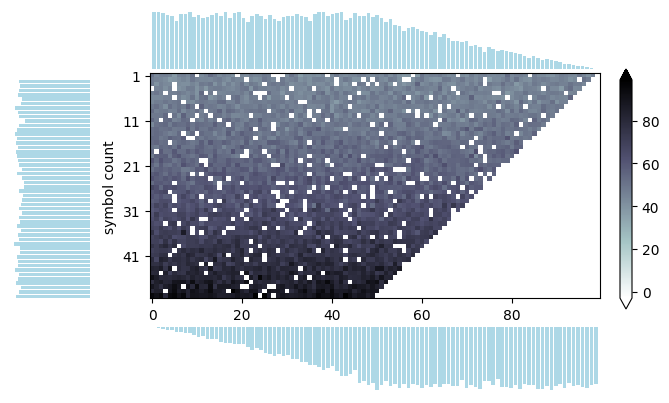

In [22]:
fig = plt.figure(figsize=(10, 6))
bar_color = 'lightblue'
cmap = 'bone_r'

ax = plt.axes([0.18, 0.72, 0.49, 0.1])
ax.bar(addon_range, input_stats.sum(axis=0), color=bar_color, align='center')
ax.axis('off')

ax = plt.axes([0.2, 0.2, 0.45, 0.65])
ax.imshow( input_stats, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')
#ax.axis('off')

ax = plt.axes([0.67, 0.32, 0.15, 0.4])
norm = matplotlib.colors.Normalize(vmin=-3, vmax=99)
cbar = ax.figure.colorbar(
            matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
            ax=ax, pad=.05, extend='both', fraction=1)
ax.axis('off')

ax = plt.axes([0.18, 0.18, 0.49, 0.11])
ax.bar(addon_range, output_stats, color=bar_color, align='center')
ax.invert_yaxis()
ax.axis('off')

ax = plt.axes([0.06, 0.32, 0.08, 0.4]) 
ax.barh(count_range, input_stats.sum(axis=1), color=bar_color, align='center')
ax.invert_xaxis()
ax.invert_yaxis()
ax.axis('off')

fig.savefig(f"figures/count_{task}_train_distr.png", bbox_inches='tight', dpi=150)
plt.show()

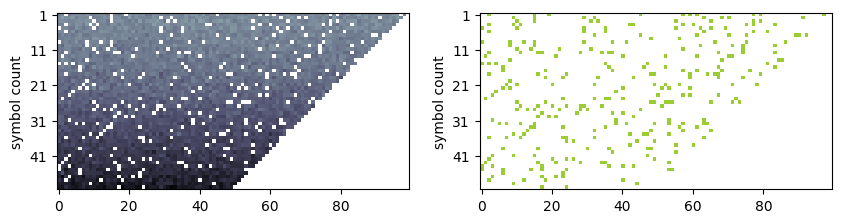

In [15]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","yellowgreen"])
fig = plt.figure(figsize=(10, 4))

ax = fig.add_subplot(121)
ax.imshow(input_stats, cmap='bone_r', interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')

ax = fig.add_subplot(122)
ax.imshow(input_stats_val, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')


plt.show()

In [16]:
# with open(f"../data/rasp_primitives/counting_{task}/train.txt", "w") as f:
#     for x in train_data:
#         f.write(json.dumps(x) + "\n")
# with open(f"../data/rasp_primitives/counting_{task}/val.txt", "w") as f:
#     for x in val_data:
#         f.write(json.dumps(x) + "\n")

In [9]:
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

['1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [4]:
input_stats = np.zeros((len(count_range_ood), len(addon_range)))
output_stats = np.zeros(len(addon_range))
data_ood = []
for count in count_range_ood:
    for addon in addon_range[:-count]:
        data_ood.append(([one() for i in range(count)] + [str(addon)], [str(x) for x in range(1, count+1)] + [str(addon+count)]))
        input_stats[count-count_range_ood[0], addon-1] += 1
        output_stats[addon+count-1] += 1


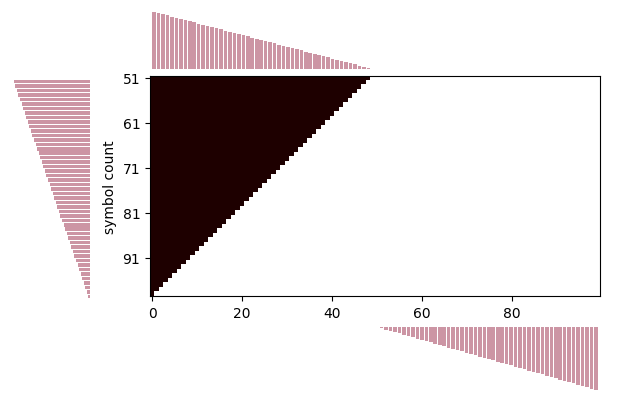

In [5]:
fig = plt.figure(figsize=(10, 6))
bar_color = '#cc95a4'
cmap = 'pink_r'
ax = plt.axes([0.18, 0.72, 0.49, 0.1])
ax.bar(addon_range, input_stats.sum(axis=0), color=bar_color, align='center')
ax.axis('off')

ax = plt.axes([0.2, 0.2, 0.45, 0.65])
ax.imshow( input_stats, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range_ood), 10), count_range_ood[::10])
ax.set_ylabel('symbol count')
#ax.axis('off')

# ax = plt.axes([0.67, 0.32, 0.15, 0.4])
# norm = matplotlib.colors.Normalize(vmin=-3, vmax=99)
# cbar = ax.figure.colorbar(
#             matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
#             ax=ax, pad=.05, extend='both', fraction=1)
# ax.axis('off')

ax = plt.axes([0.18, 0.18, 0.49, 0.11])
ax.bar(addon_range, output_stats, color=bar_color, align='center')
ax.invert_yaxis()
ax.axis('off')

ax = plt.axes([0.06, 0.32, 0.08, 0.4]) 
ax.barh(count_range_ood, input_stats.sum(axis=1), color=bar_color, align='center')
ax.invert_xaxis()
ax.invert_yaxis()
ax.axis('off')

plt.show()

In [6]:
with open(f"../data/rasp_primitives/counting_{task}/ood_test.txt", "w") as f:
    for x in data_ood:
        f.write(json.dumps(x) + "\n")

In [6]:
# tmp, lines = [], []
# with open(f"../data/rasp_primitives/counting_{task}/train.txt", "r") as f:
#     _lines = f.readlines()
#     for l in _lines:
#         x, y = json.loads(l)
#         if tuple(y[-2:]) not in tmp:
#             lines.append(l)
#             tmp.append(tuple(y[-2:]))
# print(len(lines))
with open(f"../data/rasp_primitives/counting_{task}/train_deduplicate.txt", "w") as f:
    for x in lines: f.write(x)

## Vanilla Plain

In [29]:
count_range = range(1, 51)
count_range_ood = range(51, 100)
num_val = 10
num_train = 1000000
num_data = num_train + num_val

In [30]:
# create training set

val_data = []
for t in trange(num_val):
    count = list(count_range)[-1]
    #val_data.append(([one() for x in range(count)], [str(x) for x in range(1, count+1)]))
    val_data.append((['1'] + [one() for x in range(count)], ['-1'] + [str(x) for x in range(1+1, 1+count+1)]))
    
train_data = []
for t in trange(num_train):
    count = list(count_range)[-1]
    #train_data.append(([one() for x in range(count)], [str(x) for x in range(1, count+1)]))
    train_data.append((['1'] + [one() for x in range(count)], ['-1'] + [str(x) for x in range(1+1, 1+count+1)]))
   
print(len(train_data), len(val_data))

100%|██████████| 1000000/1000000 [00:17<00:00, 56246.30it/s]

1000000 10


In [31]:
print(task)
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

samesymbol_plain2
['-1', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '6', '7', '8', '9', 'a']


In [32]:
os.makedirs(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}", exist_ok=True)
os.makedirs(f"../data/rasp_primitives/counting_{task}", exist_ok=True)
with open(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
with open(f"../data/rasp_primitives/counting_{task}/val.txt", "w") as f:
    for x in val_data:
        f.write(json.dumps(x) + "\n")

In [33]:
data_ood = []
for count in count_range_ood:
    #data_ood.append(([one() for x in range(count)], [str(x) for x in range(1, count+1)]))
    data_ood.append((['1'] + [one() for x in range(count)], ['-1'] + [str(x) for x in range(1+1, 1+count+1)]))
print(len(data_ood))
print(sorted(list(set([w for x in data_ood for w in x[0]] + [w for x in data_ood for w in x[1]]))))

49
['-1', '1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', 'a']


In [34]:
with open(f"../data/rasp_primitives/counting_{task}/ood_test.txt", "w") as f:
    for x in data_ood:
        f.write(json.dumps(x) + "\n")

## Vanilla + Shiftedstart

In [3]:
count_range = range(1, 51)
count_range_ood = range(51, 100)
addon_range = range(1, 101)
count_prob = [1] * len(count_range)
count_ood_prob = [math.sqrt((100-x)/50) for x in count_range_ood]
addon_prob = [1] * len(addon_range)
num_val = 300
num_train = 1000000
num_data = num_train + num_val

In [ ]:
# create training set
input_stats = np.zeros((len(count_range), len(addon_range)))
output_stats = np.zeros(len(addon_range))

for i in trange(num_train//2):
    count = random.choices(count_range, count_prob)[0]
    addon = random.choices(addon_range[:-count], addon_prob[:-count])[0]
    input_stats[count-1, addon-1] += 1
    #output_stats[addon+count-1] += 1

# create val set
val_data = []
input_stats_val = np.zeros_like(input_stats)
numr, numc = input_stats.shape
for i in random.sample(list(np.flatnonzero(input_stats)), num_val):
    r, c = i//numc, i%numc
    input_stats_val[r, c] += 1
    val_data.append(([one() for i in range(r+1)] + [str(c+1)], [str(x) for x in range(1, r+1+1)] + [str(c+1+r+1)]))
    val_data.append(([str(c+1)] + [one() for x in range(r+1)], ['-1'] + [str(x) for x in range(c+1+1, c+r+1+1+1)]))

# with open(f"../data/rasp_primitives/counting_{task}/val.txt", "r") as f:
#     lines = f.readlines()
#     for l in lines:
#         x, y = json.loads(l)
#         count, addon = int(y[-2]), int(x[-1])
#         r, c = count-1, addon-1
#         input_stats_val[r, c] += 1
#         val_data.append(([one() for i in range(r+1)] + [str(c+1)], [str(x) for x in range(1, r+1+1)] + [str(c+1+r+1)]))

train_data = []
input_stats = np.zeros((len(count_range), len(addon_range)))
while len(train_data) < num_train:
    count = random.choices(count_range, count_prob)[0]
    addon = random.choices(addon_range[:-count], addon_prob[:-count])[0]
    if input_stats_val[count-1, addon-1] == 0: 
        input_stats[count-1, addon-1] += 1
        output_stats[addon+count-1] += 1
        train_data.append(([one() for x in range(count)] + [str(addon)], [str(x) for x in range(1, count+1)] + [str(addon+count)]))
        train_data.append(([str(addon)] + [one() for x in range(count)], ['-1'] + [str(x) for x in range(addon+1, addon+count+1)]))

print(len(train_data), len(val_data))

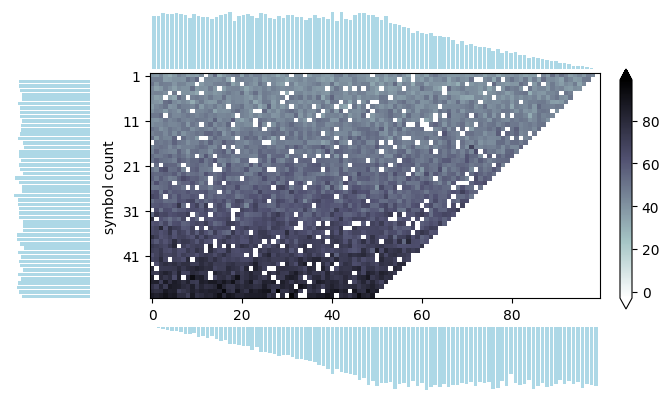

In [49]:
fig = plt.figure(figsize=(10, 6))
bar_color = 'lightblue'
cmap = 'bone_r'

ax = plt.axes([0.18, 0.72, 0.49, 0.1])
ax.bar(addon_range, input_stats.sum(axis=0), color=bar_color, align='center')
ax.axis('off')

ax = plt.axes([0.2, 0.2, 0.45, 0.65])
ax.imshow( input_stats, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')
#ax.axis('off')

ax = plt.axes([0.67, 0.32, 0.15, 0.4])
norm = matplotlib.colors.Normalize(vmin=-3, vmax=99)
cbar = ax.figure.colorbar(
            matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
            ax=ax, pad=.05, extend='both', fraction=1)
ax.axis('off')

ax = plt.axes([0.18, 0.18, 0.49, 0.11])
ax.bar(addon_range, output_stats, color=bar_color, align='center')
ax.invert_yaxis()
ax.axis('off')

ax = plt.axes([0.06, 0.32, 0.08, 0.4]) 
ax.barh(count_range, input_stats.sum(axis=1), color=bar_color, align='center')
ax.invert_xaxis()
ax.invert_yaxis()
ax.axis('off')

fig.savefig(f"figures/count_{task}_train_distr.png", bbox_inches='tight', dpi=150)
plt.show()

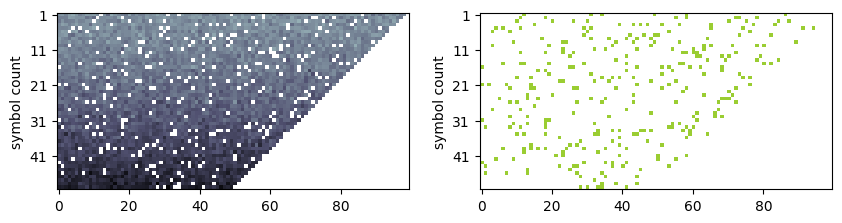

In [50]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","yellowgreen"])
fig = plt.figure(figsize=(10, 4))

ax = fig.add_subplot(121)
ax.imshow(input_stats, cmap='bone_r', interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')

ax = fig.add_subplot(122)
ax.imshow(input_stats_val, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')


plt.show()

In [51]:
print(task)
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

samesymbol_shiftedstart
['-1', '1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', 'a']


In [52]:
with open(f"../data/rasp_primitives/counting_{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
with open(f"../data/rasp_primitives/counting_{task}/val.txt", "w") as f:
    for x in val_data:
        f.write(json.dumps(x) + "\n")

In [53]:
data_ood = []
for count in count_range_ood:
    for addon in addon_range[:-count]:
        data_ood.append(([one() for x in range(count)] + [str(addon)], [str(x) for x in range(1, count+1)] + [str(addon+count)]))
        data_ood.append(([str(addon)] + [one() for x in range(count)], ['-1'] + [str(x) for x in range(addon+1, addon+count+1)]))


In [54]:
with open(f"../data/rasp_primitives/counting_{task}/ood_test.txt", "w") as f:
    for x in data_ood:
        f.write(json.dumps(x) + "\n")

## Shiftedstart (2)

In [3]:
count_range = range(1, 51)
count_range_ood = range(51, 100)
addon_range = range(1, 101)
count_prob = [1] * len(count_range)
count_ood_prob = [math.sqrt((100-x)/50) for x in count_range_ood]
addon_prob = [1] * len(addon_range)
num_val = 300
num_train = 1000000
num_data = num_train + num_val

In [4]:
# create training set
input_stats = np.zeros((len(count_range), len(addon_range)))
output_stats = np.zeros(len(addon_range))

for i in trange(num_train):
    count = random.choices(count_range, count_prob)[0]
    addon = random.choices(addon_range[:-count], addon_prob[:-count])[0]
    input_stats[count-1, addon-1] += 1
    #output_stats[addon+count-1] += 1

# create val set
val_data = []
input_stats_val = np.zeros_like(input_stats)
numr, numc = input_stats.shape
for i in random.sample(list(np.flatnonzero(input_stats)), num_val):
    r, c = i//numc, i%numc
    input_stats_val[r, c] += 1
    val_data.append(([str(c+1)] + [one() for x in range(r+1)], ['-1'] + [str(x) for x in range(c+1+1, c+r+1+1+1)]))

train_data = []
input_stats = np.zeros((len(count_range), len(addon_range)))
while len(train_data) < num_train:
    count = random.choices(count_range, count_prob)[0]
    addon = random.choices(addon_range[:-count], addon_prob[:-count])[0]
    if input_stats_val[count-1, addon-1] == 0: 
        input_stats[count-1, addon-1] += 1
        output_stats[addon+count-1] += 1
        train_data.append(([str(addon)] + [one() for x in range(count)], ['-1'] + [str(x) for x in range(addon+1, addon+count+1)]))

print(len(train_data), len(val_data))

100%|██████████| 1000000/1000000 [00:04<00:00, 204829.00it/s]


1000000 300


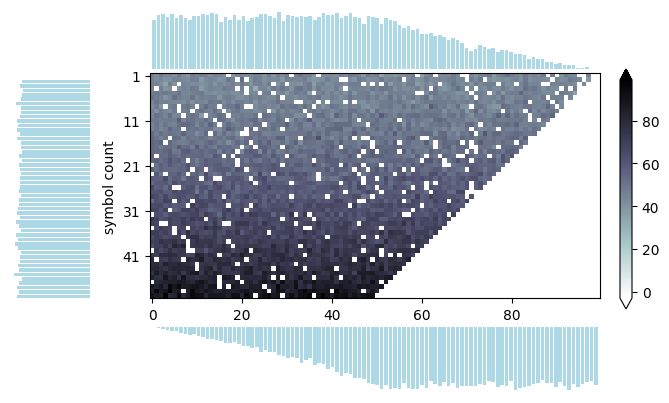

In [5]:
fig = plt.figure(figsize=(10, 6))
bar_color = 'lightblue'
cmap = 'bone_r'

ax = plt.axes([0.18, 0.72, 0.49, 0.1])
ax.bar(addon_range, input_stats.sum(axis=0), color=bar_color, align='center')
ax.axis('off')

ax = plt.axes([0.2, 0.2, 0.45, 0.65])
ax.imshow( input_stats, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')
#ax.axis('off')

ax = plt.axes([0.67, 0.32, 0.15, 0.4])
norm = matplotlib.colors.Normalize(vmin=-3, vmax=99)
cbar = ax.figure.colorbar(
            matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
            ax=ax, pad=.05, extend='both', fraction=1)
ax.axis('off')

ax = plt.axes([0.18, 0.18, 0.49, 0.11])
ax.bar(addon_range, output_stats, color=bar_color, align='center')
ax.invert_yaxis()
ax.axis('off')

ax = plt.axes([0.06, 0.32, 0.08, 0.4]) 
ax.barh(count_range, input_stats.sum(axis=1), color=bar_color, align='center')
ax.invert_xaxis()
ax.invert_yaxis()
ax.axis('off')

fig.savefig(f"figures/count_{task}_train_distr.png", bbox_inches='tight', dpi=150)
plt.show()

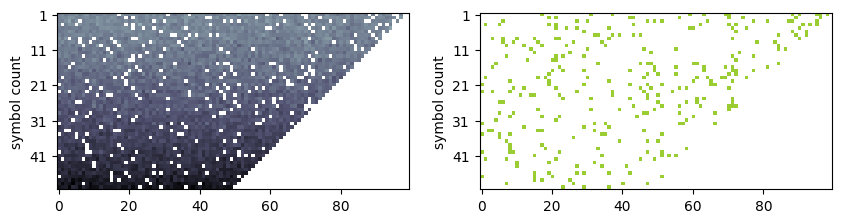

In [6]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","yellowgreen"])
fig = plt.figure(figsize=(10, 4))

ax = fig.add_subplot(121)
ax.imshow(input_stats, cmap='bone_r', interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')

ax = fig.add_subplot(122)
ax.imshow(input_stats_val, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')


plt.show()

In [7]:
print(task)
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

counting_samesymbol_shiftedstart2
['-1', '1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', 'a']


In [8]:
os.makedirs(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}", exist_ok=True)
os.makedirs(f"../data/rasp_primitives/counting_{task}", exist_ok=True)
with open(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
with open(f"../data/rasp_primitives/counting_{task}/val.txt", "w") as f:
    for x in val_data:
        f.write(json.dumps(x) + "\n")

In [9]:
data_ood = []
for count in count_range_ood:
    for addon in addon_range[:-count]:
        data_ood.append(([str(addon)] + [one() for x in range(count)], ['-1'] + [str(x) for x in range(addon+1, addon+count+1)]))


In [10]:
with open(f"../data/rasp_primitives/counting_{task}/ood_test.txt", "w") as f:
    for x in data_ood:
        f.write(json.dumps(x) + "\n")

## Shiftedstart (2) + Pad Helper

In [3]:
if "blankhelper" in task:
    helper_tok = '<blk>'
elif "padhelper" in task:
    helper_tok = '<pad>'
else:
    pass

In [4]:
count_range = range(1, 51)
count_range_ood = range(51, 100)
addon_range = range(1, 101)
count_prob = [1] * len(count_range)
count_ood_prob = [math.sqrt((100-x)/50) for x in count_range_ood]
addon_prob = [1] * len(addon_range)
num_val = 300
num_train = 1000000
num_data = num_train + num_val

In [6]:
# create training set
input_stats = np.zeros((len(count_range), len(addon_range)))
output_stats = np.zeros(len(addon_range))

for i in trange(num_train):
    count = random.choices(count_range, count_prob)[0]
    addon = random.choices(addon_range[:-count], addon_prob[:-count])[0]
    input_stats[count-1, addon-1] += 1
    #output_stats[addon+count-1] += 1

# create val set
val_data = []
input_stats_val = np.zeros_like(input_stats)
numr, numc = input_stats.shape
for i in random.sample(list(np.flatnonzero(input_stats)), num_val):
    r, c = i//numc, i%numc
    input_stats_val[r, c] += 1
    #val_data.append(([str(c+1)] + [one() for x in range(r+1)], ['-1'] + [str(x) for x in range(c+1+1, c+r+1+1+1)]))
    x, y = [str(c+1), helper_tok], ['-1', str(c+1)]
    for i in range(r+1):
        x.extend([one(), helper_tok])
    for i in range(c+1+1, c+1+r+1+1):
        y.extend(['-1', str(i)])
    val_data.append((x, y))

train_data = []
input_stats = np.zeros((len(count_range), len(addon_range)))
while len(train_data) < num_train:
    count = random.choices(count_range, count_prob)[0]
    addon = random.choices(addon_range[:-count], addon_prob[:-count])[0]
    if input_stats_val[count-1, addon-1] == 0: 
        input_stats[count-1, addon-1] += 1
        output_stats[addon+count-1] += 1
        #train_data.append(([str(addon)] + [one() for x in range(count)], ['-1'] + [str(x) for x in range(addon+1, addon+count+1)]))
        x, y = [str(addon), helper_tok], ['-1', str(addon)]
        for i in range(count):
            x.extend([one(), helper_tok])
        for i in range(addon+1, addon+count+1):
            y.extend(['-1', str(i)])
        train_data.append((x, y))

print(len(train_data), len(val_data))

100%|██████████| 1000000/1000000 [00:04<00:00, 205961.18it/s]


1000000 300


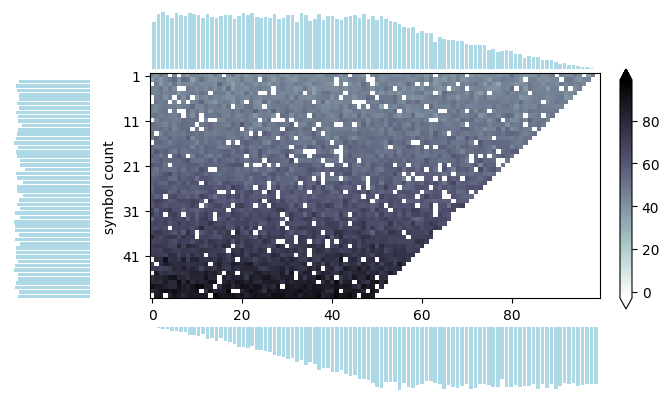

In [7]:
fig = plt.figure(figsize=(10, 6))
bar_color = 'lightblue'
cmap = 'bone_r'

ax = plt.axes([0.18, 0.72, 0.49, 0.1])
ax.bar(addon_range, input_stats.sum(axis=0), color=bar_color, align='center')
ax.axis('off')

ax = plt.axes([0.2, 0.2, 0.45, 0.65])
ax.imshow( input_stats, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')
#ax.axis('off')

ax = plt.axes([0.67, 0.32, 0.15, 0.4])
norm = matplotlib.colors.Normalize(vmin=-3, vmax=99)
cbar = ax.figure.colorbar(
            matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
            ax=ax, pad=.05, extend='both', fraction=1)
ax.axis('off')

ax = plt.axes([0.18, 0.18, 0.49, 0.11])
ax.bar(addon_range, output_stats, color=bar_color, align='center')
ax.invert_yaxis()
ax.axis('off')

ax = plt.axes([0.06, 0.32, 0.08, 0.4]) 
ax.barh(count_range, input_stats.sum(axis=1), color=bar_color, align='center')
ax.invert_xaxis()
ax.invert_yaxis()
ax.axis('off')

fig.savefig(f"figures/count_{task}_train_distr.png", bbox_inches='tight', dpi=150)
plt.show()

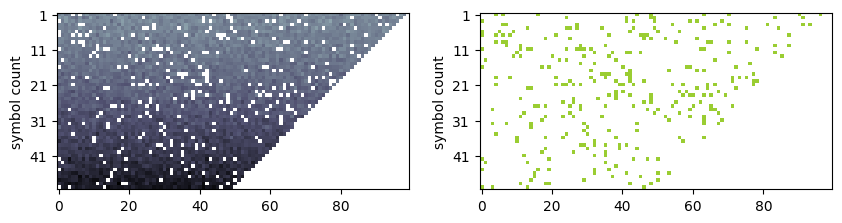

In [8]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","yellowgreen"])
fig = plt.figure(figsize=(10, 4))

ax = fig.add_subplot(121)
ax.imshow(input_stats, cmap='bone_r', interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')

ax = fig.add_subplot(122)
ax.imshow(input_stats_val, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')


plt.show()

In [9]:
print(task)
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

samesymbol_shiftedstart2_padhelper
['-1', '1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '<pad>', 'a']


In [10]:
os.makedirs(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}", exist_ok=True)
os.makedirs(f"../data/rasp_primitives/counting_{task}", exist_ok=True)
with open(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
with open(f"../data/rasp_primitives/counting_{task}/val.txt", "w") as f:
    for x in val_data:
        f.write(json.dumps(x) + "\n")

In [11]:
input_stats = np.zeros((len(count_range_ood), len(addon_range)))
output_stats = np.zeros(len(addon_range))
data_ood = []
for count in count_range_ood:
    for addon in addon_range[:-count]:
        #data_ood.append(([str(addon)] + [one() for x in range(count)], ['-1'] + [str(x) for x in range(addon+1, addon+count+1)]))
        input_stats[count-count_range_ood[0], addon-1] += 1
        output_stats[addon+count-1] += 1
        x, y = [str(addon), helper_tok], ['-1', str(addon)]
        for i in range(count):
            x.extend([one(), helper_tok])
        for i in range(addon+1, addon+count+1):
            y.extend(['-1', str(i)])
        data_ood.append((x, y))

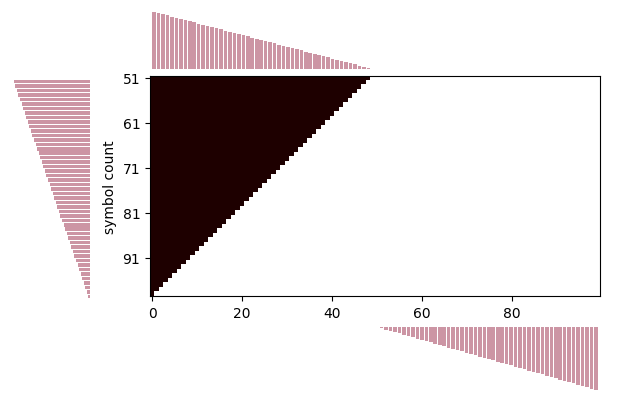

In [12]:
fig = plt.figure(figsize=(10, 6))
bar_color = '#cc95a4'
cmap = 'pink_r'
ax = plt.axes([0.18, 0.72, 0.49, 0.1])
ax.bar(addon_range, input_stats.sum(axis=0), color=bar_color, align='center')
ax.axis('off')

ax = plt.axes([0.2, 0.2, 0.45, 0.65])
ax.imshow( input_stats, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range_ood), 10), count_range_ood[::10])
ax.set_ylabel('symbol count')
#ax.axis('off')

# ax = plt.axes([0.67, 0.32, 0.15, 0.4])
# norm = matplotlib.colors.Normalize(vmin=-3, vmax=99)
# cbar = ax.figure.colorbar(
#             matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
#             ax=ax, pad=.05, extend='both', fraction=1)
# ax.axis('off')

ax = plt.axes([0.18, 0.18, 0.49, 0.11])
ax.bar(addon_range, output_stats, color=bar_color, align='center')
ax.invert_yaxis()
ax.axis('off')

ax = plt.axes([0.06, 0.32, 0.08, 0.4]) 
ax.barh(count_range_ood, input_stats.sum(axis=1), color=bar_color, align='center')
ax.invert_xaxis()
ax.invert_yaxis()
ax.axis('off')

plt.show()

In [13]:
with open(f"../data/rasp_primitives/counting_{task}/ood_test.txt", "w") as f:
    for x in data_ood:
        f.write(json.dumps(x) + "\n")

## Shiftedstart (3)

In [7]:
count_range = range(1, 51)
count_range_ood = range(51, 100)
addon_range = range(1, 51)
count_prob = [1] * len(count_range)
num_val = 300
num_train = 1000000
num_data = num_train + num_val

In [10]:
# create training set

val_data = []
for addon in addon_range:
    count = list(count_range)[-1]
    val_data.append(([str(addon)] + [one() for x in range(count)], ['-1'] + [str(x) for x in range(addon+1, addon+count+1)]))
    
train_data = []
for i in trange(num_train // len(list(addon_range))):
    for addon in addon_range:
        count = list(count_range)[-1]
        train_data.append(([str(addon)] + [one() for x in range(count)], ['-1'] + [str(x) for x in range(addon+1, addon+count+1)]))
   
print(len(train_data), len(val_data))

100%|██████████| 20000/20000 [00:18<00:00, 1081.32it/s]

1000000 50


In [11]:
print(task)
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

samesymbol_shiftedstart3
['-1', '1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', 'a']


In [15]:
os.makedirs(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}", exist_ok=True)
os.makedirs(f"../data/rasp_primitives/counting_{task}", exist_ok=True)
with open(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
with open(f"../data/rasp_primitives/counting_{task}/val.txt", "w") as f:
    for x in val_data:
        f.write(json.dumps(x) + "\n")

In [14]:
data_ood = []
for count in count_range_ood:
    for addon in addon_range:
        if count + addon > 100: continue
        data_ood.append(([str(addon)] + [one() for x in range(count)], ['-1'] + [str(x) for x in range(addon+1, addon+count+1)]))
print(len(data_ood))
    

1225


In [16]:
with open(f"../data/rasp_primitives/counting_{task}/ood_test.txt", "w") as f:
    for x in data_ood:
        f.write(json.dumps(x) + "\n")

## Shiftedstart (3) + Pad Helper

In [19]:
if "blankhelper" in task:
    helper_tok = '<blk>'
elif "padhelper" in task:
    helper_tok = '<pad>'
else:
    pass

In [20]:
count_range = range(1, 51)
count_range_ood = range(51, 100)
addon_range = range(1, 51)
count_prob = [1] * len(count_range)
num_val = 300
num_train = 1000000
num_data = num_train + num_val

In [23]:
# create training set

val_data = []
for addon in addon_range:
    count = list(count_range)[-1]
    x, y = [str(addon), helper_tok], ['-1', str(addon)]
    for i in range(count):
        x.extend([one(), helper_tok])
    for i in range(addon+1, addon+count+1):
        y.extend(['-1', str(i)])
    val_data.append((x, y))

train_data = []
for i in trange(num_train // len(list(addon_range))):
    for addon in addon_range:
        count = list(count_range)[-1]
        x, y = [str(addon), helper_tok], ['-1', str(addon)]
        for i in range(count):
            x.extend([one(), helper_tok])
        for i in range(addon+1, addon+count+1):
            y.extend(['-1', str(i)])
        train_data.append((x, y))
        
print(len(train_data), len(val_data))

100%|██████████| 20000/20000 [00:30<00:00, 659.54it/s]

1000000 50


In [24]:
print(task)
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

samesymbol_shiftedstart3_padhelper
['-1', '1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '<pad>', 'a']


In [25]:
os.makedirs(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}", exist_ok=True)
os.makedirs(f"../data/rasp_primitives/counting_{task}", exist_ok=True)
with open(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
with open(f"../data/rasp_primitives/counting_{task}/val.txt", "w") as f:
    for x in val_data:
        f.write(json.dumps(x) + "\n")

In [26]:
data_ood = []
for count in count_range_ood:
    for addon in addon_range:
        if count + addon > 100: continue
        x, y = [str(addon), helper_tok], ['-1', str(addon)]
        for i in range(count):
            x.extend([one(), helper_tok])
        for i in range(addon+1, addon+count+1):
            y.extend(['-1', str(i)])
        data_ood.append((x, y))
print(len(data_ood))
    

1225


In [27]:
with open(f"../data/rasp_primitives/counting_{task}/ood_test.txt", "w") as f:
    for x in data_ood:
        f.write(json.dumps(x) + "\n")

## Vanilla + Bigram

In [31]:
count_range = range(1, 51)
count_range_ood = range(51, 101)
count_prob = [1] * len(count_range)
count_ood_prob = [math.sqrt((100-x)/50) for x in count_range_ood]
num_val = 300
num_train = 1000000
num_ood = 3000
bigram_priming_ratio = 0.01
num_data = num_train + num_val

In [26]:
# create training set
seen_lengths = []
train_data = []
for i in trange(num_train):
    count = random.choices(count_range, count_prob)[0]
    seen_lengths.append(count)
    train_data.append(([one() for x in range(count)], [str(x) for x in range(1, count+1)]))

for i in range(int(num_train * bigram_priming_ratio)):
    count = list(count_range_ood)[-1]
    seq = [str(x) for x in range(1, count+1)]
    train_data.append([seq[:-1], seq[1:]])

# create val set
val_data = []
for i in trange(num_val):
    count = random.choices(count_range, count_prob)[0]
    val_data.append(([one() for x in range(count)], [str(x) for x in range(1, count+1)]))

print(len(train_data), len(val_data))

100%|██████████| 300/300 [00:00<00:00, 73288.55it/s]

1010000 300


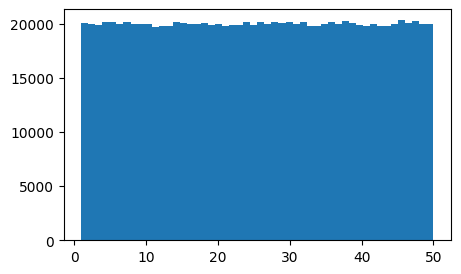

In [27]:
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)
ax.hist(seen_lengths, bins=len(Counter(seen_lengths)))
plt.show()

In [28]:
print(task)
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

diffsymbol_addbigram
['1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [29]:
with open(f"../data/rasp_primitives/counting_{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
with open(f"../data/rasp_primitives/counting_{task}/val.txt", "w") as f:
    for x in val_data:
        f.write(json.dumps(x) + "\n")

In [32]:
ood_data = []
for c in range(num_ood // len(list(count_range_ood))):
    for count in count_range_ood:
        ood_data.append(([one() for x in range(count)], [str(x) for x in range(1, count+1)]))


In [33]:
with open(f"../data/rasp_primitives/counting_{task}/ood_test.txt", "w") as f:
    for x in ood_data:
        f.write(json.dumps(x) + "\n")

## Blank Helper / Pad Helper

In [46]:
if "blankhelper" in task:
    helper_tok = '<blk>'
elif "padhelper" in task:
    helper_tok = '<pad>'
else:
    pass

In [34]:
count_range = range(1, 51)
count_range_ood = range(51, 100)
addon_range = range(1, 101)
count_prob = [1] * len(count_range)
count_ood_prob = [math.sqrt((100-x)/50) for x in count_range_ood]
addon_prob = [1] * len(addon_range)
num_val = 300
num_train = 1000000
num_data = num_train + num_val

In [35]:
# create training set
input_stats = np.zeros((len(count_range), len(addon_range)))
output_stats = np.zeros(len(addon_range))

for i in trange(num_train):
    count = random.choices(count_range, count_prob)[0]
    addon = random.choices(addon_range[:-count], addon_prob[:-count])[0]
    input_stats[count-1, addon-1] += 1

# create val set
val_data = []
input_stats_val = np.zeros_like(input_stats)
numr, numc = input_stats.shape
for i in random.sample(list(np.flatnonzero(input_stats)), num_val):
    r, c = i//numc, i%numc
    input_stats_val[r, c] += 1
    #val_data.append(([one() for i in range(r+1)] + [str(c+1)], [str(x) for x in range(1, r+1+1)] + [str(c+1+r+1)]))
    x, y = [], []
    for i in range(r+1):
        x.extend([one(), helper_tok])
    x.append(str(c+1))
    for i in range(1, r+1+1):
        y.extend(['-1', str(i)])
    y.append(str(c+1+r+1))
    val_data.append((x, y))
# with open(f"../data/rasp_primitives/counting_{task}/val.txt", "r") as f:
#     lines = f.readlines()
#     for l in lines:
#         x, y = json.loads(l)
#         count, addon = int(y[-2]), int(x[-1])
#         r, c = count-1, addon-1
#         input_stats_val[r, c] += 1
#         val_data.append(([one() for i in range(r+1)] + [str(c+1)], [str(x) for x in range(1, r+1+1)] + [str(c+1+r+1)]))

train_data = []
input_stats = np.zeros((len(count_range), len(addon_range)))
while len(train_data) < num_train:
    count = random.choices(count_range, count_prob)[0]
    addon = random.choices(addon_range[:-count], addon_prob[:-count])[0]
    if input_stats_val[count-1, addon-1] == 0: 
        input_stats[count-1, addon-1] += 1
        output_stats[addon+count-1] += 1
        #train_data.append(([one() for i in range(count)] + [str(addon)], [str(x) for x in range(1, count+1)] + [str(addon+count)]))
        x, y = [], []
        for i in range(count):
            x.extend([one(), helper_tok])
        x.append(str(addon))
        for i in range(1, count+1):
            y.extend(['-1', str(i)])
        y.append(str(addon+count))
        train_data.append((x, y))
print(len(train_data), len(val_data))

100%|██████████| 1000000/1000000 [00:05<00:00, 178171.44it/s]


1000000 300


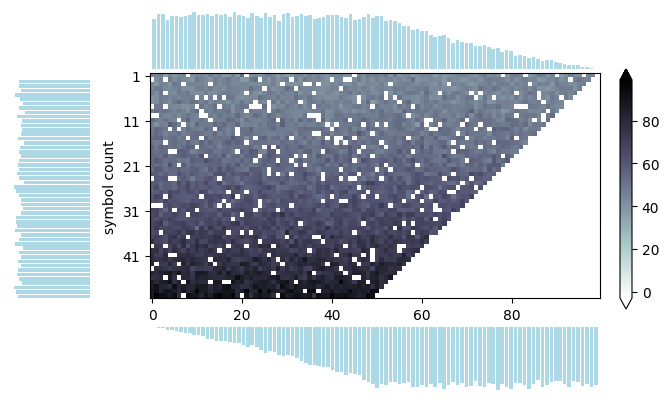

In [36]:
fig = plt.figure(figsize=(10, 6))
bar_color = 'lightblue'
cmap = 'bone_r'

ax = plt.axes([0.18, 0.72, 0.49, 0.1])
ax.bar(addon_range, input_stats.sum(axis=0), color=bar_color, align='center')
ax.axis('off')

ax = plt.axes([0.2, 0.2, 0.45, 0.65])
ax.imshow( input_stats, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')
#ax.axis('off')

ax = plt.axes([0.67, 0.32, 0.15, 0.4])
norm = matplotlib.colors.Normalize(vmin=-3, vmax=99)
cbar = ax.figure.colorbar(
            matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
            ax=ax, pad=.05, extend='both', fraction=1)
ax.axis('off')

ax = plt.axes([0.18, 0.18, 0.49, 0.11])
ax.bar(addon_range, output_stats, color=bar_color, align='center')
ax.invert_yaxis()
ax.axis('off')

ax = plt.axes([0.06, 0.32, 0.08, 0.4]) 
ax.barh(count_range, input_stats.sum(axis=1), color=bar_color, align='center')
ax.invert_xaxis()
ax.invert_yaxis()
ax.axis('off')

fig.savefig(f"figures/count_{task}_train_distr.png", bbox_inches='tight', dpi=150)
plt.show()

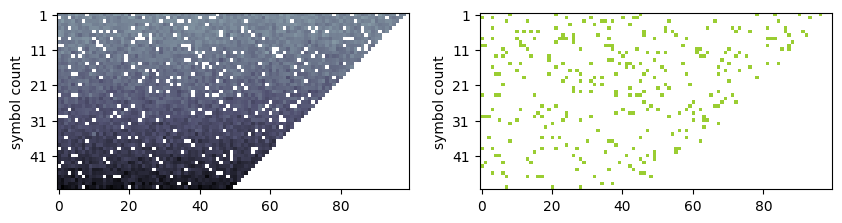

In [37]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","yellowgreen"])
fig = plt.figure(figsize=(10, 4))

ax = fig.add_subplot(121)
ax.imshow(input_stats, cmap='bone_r', interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')

ax = fig.add_subplot(122)
ax.imshow(input_stats_val, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range), 10), count_range[::10])
ax.set_ylabel('symbol count')


plt.show()

In [38]:
task

'samesymbol_padhelper'

In [39]:
with open(f"../data/rasp_primitives/counting_{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
with open(f"../data/rasp_primitives/counting_{task}/val.txt", "w") as f:
    for x in val_data:
        f.write(json.dumps(x) + "\n")

In [40]:
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

['-1', '1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '<pad>', 'a']


In [41]:
input_stats = np.zeros((len(count_range_ood), len(addon_range)))
output_stats = np.zeros(len(addon_range))
data_ood = []
for count in count_range_ood:
    for addon in addon_range[:-count]:
        #data_ood.append(([one() for i in range(count)] + [str(addon)], [str(x) for x in range(1, count+1)] + [str(addon+count)]))
        input_stats[count-count_range_ood[0], addon-1] += 1
        output_stats[addon+count-1] += 1
        x, y = [], []
        for i in range(count):
            x.extend([one(), helper_tok])
        x.append(str(addon))
        for i in range(1, count+1):
            y.extend(['-1', str(i)])
        y.append(str(addon+count))
        data_ood.append((x, y))


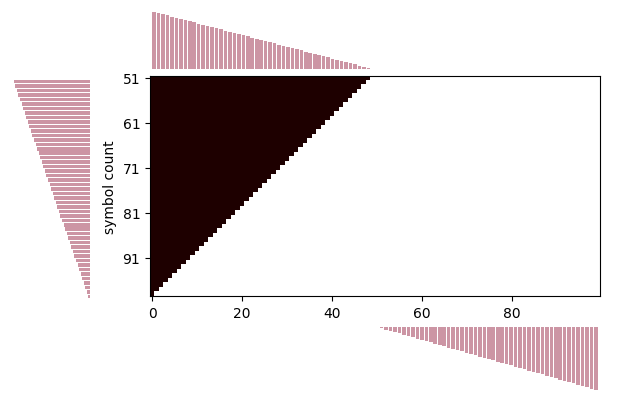

In [42]:
fig = plt.figure(figsize=(10, 6))
bar_color = '#cc95a4'
cmap = 'pink_r'
ax = plt.axes([0.18, 0.72, 0.49, 0.1])
ax.bar(addon_range, input_stats.sum(axis=0), color=bar_color, align='center')
ax.axis('off')

ax = plt.axes([0.2, 0.2, 0.45, 0.65])
ax.imshow( input_stats, cmap=cmap, interpolation='nearest') 
ax.set_yticks(range(0, len(count_range_ood), 10), count_range_ood[::10])
ax.set_ylabel('symbol count')
#ax.axis('off')

# ax = plt.axes([0.67, 0.32, 0.15, 0.4])
# norm = matplotlib.colors.Normalize(vmin=-3, vmax=99)
# cbar = ax.figure.colorbar(
#             matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
#             ax=ax, pad=.05, extend='both', fraction=1)
# ax.axis('off')

ax = plt.axes([0.18, 0.18, 0.49, 0.11])
ax.bar(addon_range, output_stats, color=bar_color, align='center')
ax.invert_yaxis()
ax.axis('off')

ax = plt.axes([0.06, 0.32, 0.08, 0.4]) 
ax.barh(count_range_ood, input_stats.sum(axis=1), color=bar_color, align='center')
ax.invert_xaxis()
ax.invert_yaxis()
ax.axis('off')

plt.show()

In [43]:
with open(f"../data/rasp_primitives/counting_{task}/ood_test.txt", "w") as f:
    for x in data_ood:
        f.write(json.dumps(x) + "\n")

In [47]:
tmp, lines = [], []
with open(f"../data/rasp_primitives/counting_{task}/train.txt", "r") as f:
    _lines = f.readlines()
    for l in _lines:
        x, y = json.loads(l)
        if tuple(y[-2:]) not in tmp:
            lines.append(l)
            tmp.append(tuple(y[-2:]))
print(len(lines))
with open(f"../data/rasp_primitives/counting_{task}/train_deduplicate.txt", "w") as f:
    for x in lines: f.write(x)

3425


## Modular Counter

In [10]:
count_range = range(1, 91)
count_range_ood = range(91, 181)
num_val = 300
num_train = 1000000
num_data = num_train + num_val

base = int(re.findall(r'mod(\d+)', task)[0])
print(f"{task}: count x mod {base}")

diffsymbol_mod18: count x mod 18


In [11]:
# create training set
train_data = []
for i in trange(num_train // len(count_range)):
    for count in count_range:
        train_data.append(([one() for i in range(count)], [str(x%base) if x%base!=0 else str(base) for x in range(1, count+1)]))

# create val set
val_data = []
for i in trange(num_val // len(count_range)):
    for count in count_range:
        val_data.append(([one() for i in range(count)], [str(x%base) if x%base!=0 else str(base) for x in range(1, count+1)]))
print(len(train_data), len(val_data))

  0%|          | 0/11111 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 453.49it/s]

999990 270


In [12]:
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [13]:
os.makedirs(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}", exist_ok=True)
os.makedirs(f"../data/rasp_primitives/counting_{task}", exist_ok=True)
with open(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
with open(f"../data/rasp_primitives/counting_{task}/val.txt", "w") as f:
    for x in val_data:
        f.write(json.dumps(x) + "\n")

In [14]:
data_ood = []
for count in tqdm(count_range_ood):
    data_ood.append(([one() for i in range(count)], [str(x%base) if x%base!=0 else str(base) for x in range(1, count+1)]))
    if "diffsymbol" in task:
        for cyc in range(29):
            data_ood.append((
                [one() for i in range(count)], 
                [str(x%base) if x%base!=0 else str(base) for x in range(1, count+1)]
            ))
print(len(data_ood))

100%|██████████| 90/90 [00:00<00:00, 429.95it/s]

2700


In [15]:
with open(f"../data/rasp_primitives/counting_{task}/ood_test.txt", "w") as f:
    for x in data_ood:
        f.write(json.dumps(x) + "\n")

## Modular Counter + Blank / Pad Helper

In [3]:
if "blankhelper" in task:
    helper_tok = '<blk>'
elif "padhelper" in task:
    helper_tok = '<pad>'
else:
    pass

In [4]:
count_range = range(1, 51)
count_range_ood = range(51, 101)
num_val = 300
num_train = 1000000
num_data = num_train + num_val

base = int(re.findall(r'mod(\d+)', task)[0])
print(f"{task}: count x mod {base}")

samesymbol_mod10_padhelper: count x mod 10


In [5]:
# create training set
train_data = []
for i in trange(num_train // len(count_range)):
    for count in count_range:
        #train_data.append(([one() for i in range(count)], [str(x%base) if x%base!=0 else str(base) for x in range(1, count+1)]))
        x, y = [], []
        for i in range(count):
            x.extend([one(), helper_tok])
        for i in range(1, count+1):
            y.extend(['-1', str(i%base) if i%base!=0 else str(base)])
        train_data.append((x, y))

# create val set
val_data = []
for i in trange(num_val // len(count_range)):
    for count in count_range:
        #val_data.append(([one() for i in range(count)], [str(x%base) if x%base!=0 else str(base) for x in range(1, count+1)]))
        x, y = [], []
        for i in range(count):
            x.extend([one(), helper_tok])
        for i in range(1, count+1):
            y.extend(['-1', str(i%base) if i%base!=0 else str(base)])
        val_data.append((x, y))
print(len(train_data), len(val_data))

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 1785.57it/s]

1000000 300


In [6]:
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

['-1', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9', '<pad>', 'a']


In [7]:
os.makedirs(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}", exist_ok=True)
os.makedirs(f"../data/rasp_primitives/counting_{task}", exist_ok=True)
with open(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
with open(f"../data/rasp_primitives/counting_{task}/val.txt", "w") as f:
    for x in val_data:
        f.write(json.dumps(x) + "\n")

In [8]:
data_ood = []
for count in count_range_ood:
    x, y = [], []
    for i in range(count):
        x.extend([one(), helper_tok])
    for i in range(1, count+1):
        y.extend(['-1', str(i%base) if i%base!=0 else str(base)])
    data_ood.append((x, y))


In [9]:
with open(f"../data/rasp_primitives/counting_{task}/ood_test.txt", "w") as f:
    for x in data_ood:
        f.write(json.dumps(x) + "\n")

## Selective Counting

In [4]:
count_range = range(1, 51)
count_range_ood = range(51, 100)
num_val = 300
num_train = 1000000
num_data = num_train + num_val

In [25]:
# create training set
train_data = []

for cyc in trange(num_train//1275):
    for num_a in count_range:
        for num_b in range(list(count_range)[-1] - num_a+1):
            if num_a + num_b == 0: continue
            b_indices = random.sample(list(range(num_a+num_b)), num_b)
            a = np.chararray((num_a+num_b, ))
            a[:] = 'a'
            b = np.chararray((num_a+num_b, ))
            b[:] = 'b'
            s = np.chararray((num_a+num_b, ))
            s[:] = 'a'
            for i in b_indices: s[i] = 'b'
            pred_a = s == a
            pred_b = s == b
            seq = list(s.tobytes().decode("utf-8"))
            train_data.append([seq, [
                str(sum(pred_a[:i])) if seq[i-1]=='a' else str(sum(pred_b[:i]))
                for i in range(1, len(seq)+1)
                ]])

# create val set
val_data = []
for num_a in tqdm(count_range):
    for num_b in range(list(count_range)[-1] - num_a+1):
        if num_a + num_b == 0: continue
        b_indices = random.sample(list(range(num_a+num_b)), num_b)
        a = np.chararray((num_a+num_b, ))
        a[:] = 'a'
        b = np.chararray((num_a+num_b, ))
        b[:] = 'b'
        s = np.chararray((num_a+num_b, ))
        s[:] = 'a'
        for i in b_indices: s[i] = 'b'
        pred_a = s == a
        pred_b = s == b
        seq = list(s.tobytes().decode("utf-8"))
        val_data.append([seq, [
            str(sum(pred_a[:i])) if seq[i-1]=='a' else str(sum(pred_b[:i])) 
            for i in range(1, len(seq)+1)
            ]])
print(len(train_data), len(val_data))

100%|██████████| 50/50 [00:00<00:00, 144.63it/s]

999600 1275


In [26]:
print(task)
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

selective
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '6', '7', '8', '9', 'a', 'b']


In [27]:
with open(f"../data/rasp_primitives/counting_{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
with open(f"../data/rasp_primitives/counting_{task}/val.txt", "w") as f:
    for x in val_data:
        f.write(json.dumps(x) + "\n")

In [34]:
data_ood = []
tmp = list(count_range)[-1]
for cyc in range(2):
    for num_a in trange(tmp+1):
        for num_b in range(tmp+1):
            if num_a + num_b == 0: continue
            if num_a + num_b <= 50: continue
            b_indices = random.sample(list(range(num_a+num_b)), num_b)
            a = np.chararray((num_a+num_b, ))
            a[:] = 'a'
            b = np.chararray((num_a+num_b, ))
            b[:] = 'b'
            s = np.chararray((num_a+num_b, ))
            s[:] = 'a'
            for i in b_indices: s[i] = 'b'
            pred_a = s == a
            pred_b = s == b
            seq = list(s.tobytes().decode("utf-8"))
            data_ood.append([seq, [
                str(sum(pred_a[:i])) if seq[i-1]=='a' else str(sum(pred_b[:i])) 
                for i in range(1, len(seq)+1)
                ]])
print(len(data_ood))

  0%|          | 0/51 [00:00<?, ?it/s]

100%|██████████| 51/51 [00:00<00:00, 88.62it/s] 

2550


In [35]:
with open(f"../data/rasp_primitives/counting_{task}/ood_test.txt", "w") as f:
    for x in data_ood:
        f.write(json.dumps(x) + "\n")

## Selective Counter + Pad Helper

In [37]:
if "blankhelper" in task:
    helper_tok = '<blk>'
elif "padhelper" in task:
    helper_tok = '<pad>'
else:
    pass

In [38]:
count_range = range(1, 51)
count_range_ood = range(51, 100)
num_val = 300
num_train = 1000000
num_data = num_train + num_val

In [39]:
# create training set
train_data = []

for cyc in trange(num_train//1275):
    for num_a in count_range:
        for num_b in range(list(count_range)[-1] - num_a+1):
            if num_a + num_b == 0: continue
            b_indices = random.sample(list(range(num_a+num_b)), num_b)
            a = np.chararray((num_a+num_b, ))
            a[:] = 'a'
            b = np.chararray((num_a+num_b, ))
            b[:] = 'b'
            s = np.chararray((num_a+num_b, ))
            s[:] = 'a'
            for i in b_indices: s[i] = 'b'
            pred_a = s == a
            pred_b = s == b
            seq = list(s.tobytes().decode("utf-8"))
            x, y = [], []
            for i, tok in zip(range(1, len(seq)+1), seq):
                x.extend([tok, helper_tok])
            for i in range(1, len(seq)+1):
                y.extend(['-1', str(sum(pred_a[:i])) if seq[i-1]=='a' else str(sum(pred_b[:i]))])
            train_data.append((x, y))

# create val set
val_data = []
for num_a in tqdm(count_range):
    for num_b in range(list(count_range)[-1] - num_a+1):
        if num_a + num_b == 0: continue
        b_indices = random.sample(list(range(num_a+num_b)), num_b)
        a = np.chararray((num_a+num_b, ))
        a[:] = 'a'
        b = np.chararray((num_a+num_b, ))
        b[:] = 'b'
        s = np.chararray((num_a+num_b, ))
        s[:] = 'a'
        for i in b_indices: s[i] = 'b'
        pred_a = s == a
        pred_b = s == b
        seq = list(s.tobytes().decode("utf-8"))
        x, y = [], []
        for i, tok in zip(range(1, len(seq)+1), seq):
            x.extend([tok, helper_tok])
        for i in range(1, len(seq)+1):
            y.extend(['-1', str(sum(pred_a[:i])) if seq[i-1]=='a' else str(sum(pred_b[:i]))])
        val_data.append((x, y))
        
print(len(train_data), len(val_data))

100%|██████████| 50/50 [00:00<00:00, 199.61it/s]

999600 1275


In [40]:
print(task)
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

selective_padhelper
['-1', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '6', '7', '8', '9', '<pad>', 'a', 'b']


In [42]:
with open(f"../data/rasp_primitives/counting_{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
with open(f"../data/rasp_primitives/counting_{task}/val.txt", "w") as f:
    for x in val_data:
        f.write(json.dumps(x) + "\n")

In [43]:
data_ood = []
tmp = list(count_range)[-1]
for cyc in range(2):
    for num_a in trange(tmp+1):
        for num_b in range(tmp+1):
            if num_a + num_b == 0: continue
            if num_a + num_b <= 50: continue
            b_indices = random.sample(list(range(num_a+num_b)), num_b)
            a = np.chararray((num_a+num_b, ))
            a[:] = 'a'
            b = np.chararray((num_a+num_b, ))
            b[:] = 'b'
            s = np.chararray((num_a+num_b, ))
            s[:] = 'a'
            for i in b_indices: s[i] = 'b'
            pred_a = s == a
            pred_b = s == b
            seq = list(s.tobytes().decode("utf-8"))
            x, y = [], []
            for i, tok in zip(range(1, len(seq)+1), seq):
                x.extend([tok, helper_tok])
            for i in range(1, len(seq)+1):
                y.extend(['-1', str(sum(pred_a[:i])) if seq[i-1]=='a' else str(sum(pred_b[:i]))])
            data_ood.append((x, y))
print(len(data_ood))

100%|██████████| 51/51 [00:00<00:00, 89.34it/s] 

2550


In [44]:
with open(f"../data/rasp_primitives/counting_{task}/ood_test.txt", "w") as f:
    for x in data_ood:
        f.write(json.dumps(x) + "\n")

## Selective Counting 10 Items

In [3]:
import multiprocessing as mp
from joblib import Parallel, delayed
import shutil
ncpu = mp.cpu_count()

In [4]:
count_range = range(1, 51)
count_range_ood = range(51, 100)
num_train = 1000000
num_val = 2000
num_ood_test = 3000


In [5]:
# create training set
min_count_drop_prop = [0.9995, 0.985, 0.8, 0.2, 0, 0, 0, 0, 0, 0]

os.makedirs("tmp", exist_ok=True)
def job(seq_len):
    f = open(f"tmp/{seq_len}_train.txt", "w")
    for cyc in range(num_train//len(list(count_range))):
        while True:
            boundaries = [0] + sorted(random.sample(range(1, seq_len+10), 9)) + [seq_len+10]
            seq = []
            max_count = max([boundaries[i+1] - boundaries[i] - 1 for i in range(10)])
            if max_count > 10: continue
            min_count = min([boundaries[i+1] - boundaries[i] - 1 for i in range(10)])
            if seq_len > 20 and random.random() < min_count_drop_prop[min_count]: continue
            for d, i in zip("0123456789", range(10)):
                seq.extend([d] * (boundaries[i+1] - boundaries[i] - 1))
            random.shuffle(seq)
            f.write(json.dumps([seq, [str(Counter(seq[:i])[seq[i]]) for i in range(len(seq))]]) + "\n")
            break
    f.close()
    print("finish ", seq_len)

confirms = Parallel(n_jobs = ncpu, backend="multiprocessing")(delayed(job)(seq_len) for seq_len in count_range)

train_data = []
Z = defaultdict(list)
for seq_len in count_range:
    with open(f"tmp/{seq_len}_train.txt", "r") as f:
        lines = f.readlines()
        train_data.extend([json.loads(l) for l in lines])
print(len(train_data))
for x in tqdm(train_data):
    seq = x[0]
    c = Counter("".join(seq))
    for d in "0123456789":
        Z[d].append(c[d])
shutil.rmtree("tmp")

finish  1
finish  2
finish  3
finish  4
finish  5
finish  6
finish  7
finish  8
finish  14
finish  10
finish  9
finish  11
finish  12
finish  17
finish  13
finish  15
finish  16
finish  19
finish  18
finish  20
finish  47
finish  41
finish  45
finish  48
finish  43
finish  46
finish  49
finish  40
finish  38
finish  44
finish  50
finish  37
finish  36
finish  42
finish  39
finish  35
finish  32
finish  34
finish  30
finish  33
finish  31
finish  28
finish  27
finish  25
finish  29
finish  24
finish  26
finish  22
finish  23
finish  21
1000000


100%|██████████| 1000000/1000000 [00:03<00:00, 293581.62it/s]


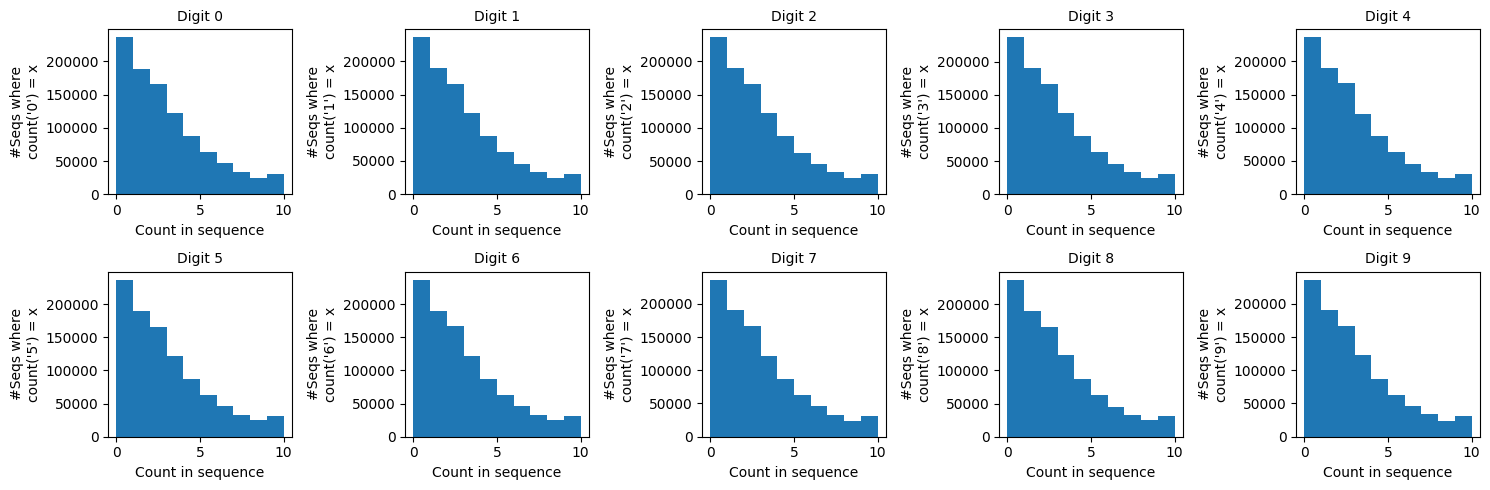

In [6]:
fig = plt.figure(figsize=(15, 5))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.hist(Z[str(i)], bins=10)
    ax.set_title(f"Digit {i}", fontsize=10)
    ax.set_xlabel("Count in sequence")
    ax.set_ylabel(f"#Seqs where\ncount('{i}') = x")
fig.tight_layout()
plt.show()

100%|██████████| 40/40 [00:06<00:00,  6.34it/s]


1000000 2000


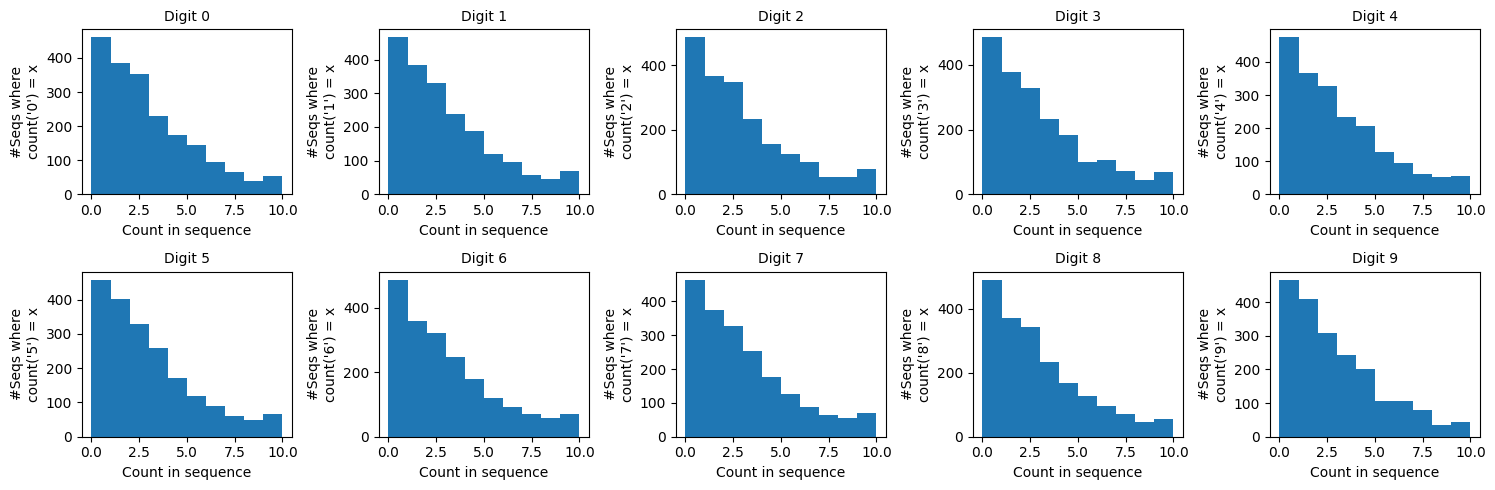

In [7]:
#create val set
val_data = []
Zv = defaultdict(list)
for cyc in trange(num_val//len(list(count_range))):
    for seq_len in count_range:
        while True:
            boundaries = [0] + sorted(random.sample(range(1, seq_len+10), 9)) + [seq_len+10]
            seq = []
            max_count = max([boundaries[i+1] - boundaries[i] - 1 for i in range(10)])
            if max_count > 10: continue
            min_count = min([boundaries[i+1] - boundaries[i] - 1 for i in range(10)])
            if seq_len > 20 and random.random() < min_count_drop_prop[min_count]: continue
            for d, i in zip("0123456789", range(10)):
                seq.extend([d] * (boundaries[i+1] - boundaries[i] - 1))
            random.shuffle(seq)
            val_data.append([seq, [str(Counter(seq[:i])[seq[i]]) for i in range(len(seq))]])
            c = Counter(seq)
            for d in "0123456789":
                Zv[d].append(c[d])
            break
print(len(train_data), len(val_data))
fig = plt.figure(figsize=(15, 5))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.hist(Zv[str(i)], bins=10)
    ax.set_title(f"Digit {i}", fontsize=10)
    ax.set_xlabel("Count in sequence")
    ax.set_ylabel(f"#Seqs where\ncount('{i}') = x")
fig.tight_layout()
plt.show()

100%|██████████| 1000000/1000000 [00:00<00:00, 1578910.83it/s]


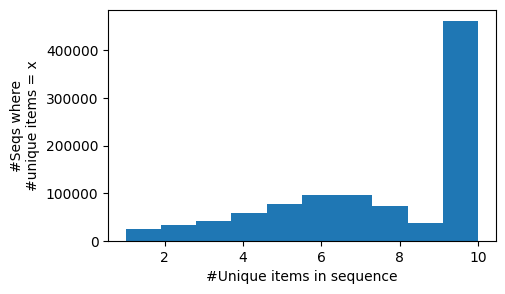

In [23]:
# histogram of #unique items
uniques = []
for x in tqdm(train_data):
    seq = x[0]
    uniques.append(len(set(seq)))
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)
ax.hist(uniques, bins=10)
ax.set_ylabel("#Seqs where\n#unique items = x")
ax.set_xlabel("#Unique items in sequence")
plt.show()

In [8]:
print(task)
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

selective_10items
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [9]:
os.makedirs(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}", exist_ok=True)
os.makedirs(f"../data/rasp_primitives/counting_{task}", exist_ok=True)
with open(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
with open(f"../data/rasp_primitives/counting_{task}/val.txt", "w") as f:
    for x in val_data:
        f.write(json.dumps(x) + "\n")

In [10]:
min_count_drop_prop = [0.99, 0.5, 0.2, 0, 0, 0, 0, 0, 0, 0]
ood_data = []
Zt = defaultdict(list)
for cyc in trange(num_ood_test//len(list(count_range_ood))):
    for seq_len in count_range_ood:
        while True:
            boundaries = [0] + sorted(random.sample(range(1, 100-seq_len+10), 9)) + [100-seq_len+10]
            seq = []
            max_count = max([boundaries[i+1] - boundaries[i] - 1 for i in range(10)])
            if max_count > 10: continue
            min_count = min([boundaries[i+1] - boundaries[i] - 1 for i in range(10)])
            if random.random() < min_count_drop_prop[min_count]: continue
            for d, i in zip("0123456789", range(10)):
                seq.extend([d] * (10 - (boundaries[i+1] - boundaries[i] - 1)))
            random.shuffle(seq)
            ood_data.append([seq, [str(Counter(seq[:i])[seq[i]]) for i in range(len(seq))]])
            c = Counter(seq)
            for d in "0123456789":
                Zt[d].append(c[d])
            break


100%|██████████| 61/61 [00:01<00:00, 33.15it/s]


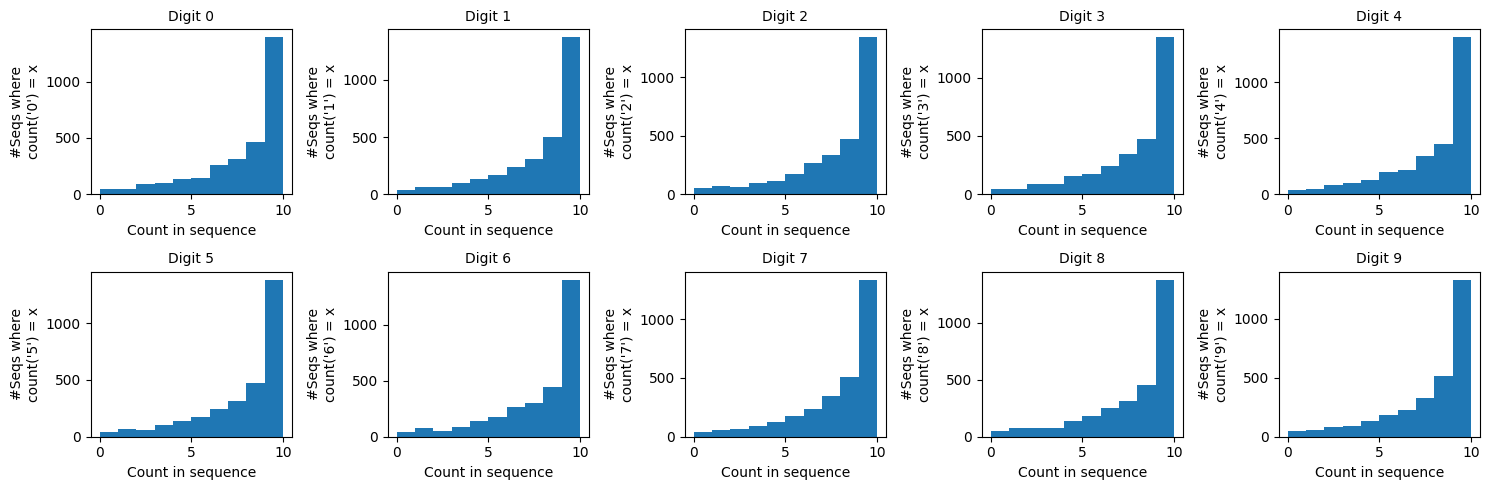

In [11]:
fig = plt.figure(figsize=(15, 5))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.hist(Zt[str(i)], bins=10)
    ax.set_title(f"Digit {i}", fontsize=10)
    ax.set_xlabel("Count in sequence")
    ax.set_ylabel(f"#Seqs where\ncount('{i}') = x")
fig.tight_layout()
plt.show()

In [12]:
print(task)
# Verify no ood counts
print(sorted(list(set([w for x in ood_data for w in x[0]] + [w for x in ood_data for w in x[1]]))))
with open(f"../data/rasp_primitives/counting_{task}/ood_test.txt", "w") as f:
    for x in ood_data:
        f.write(json.dumps(x) + "\n")

## Selective Counting 10 items + Pad Helper

In [25]:
import multiprocessing as mp
from joblib import Parallel, delayed
import shutil
ncpu = mp.cpu_count()

In [32]:
count_range = range(1, 51)
count_range_ood = range(51, 100)
num_train = 1000000
num_val = 2000
num_ood_test = 3000

if "blankhelper" in task:
    helper_tok = '<blk>'
elif "padhelper" in task:
    helper_tok = '<pad>'
else:
    pass

In [33]:
# create training set
min_count_drop_prop = [0.9995, 0.985, 0.8, 0.2, 0, 0, 0, 0, 0, 0]

os.makedirs("tmp", exist_ok=True)
def job(seq_len):
    f = open(f"tmp/{seq_len}_train.txt", "w")
    for cyc in range(num_train//len(list(count_range))):
        while True:
            boundaries = [0] + sorted(random.sample(range(1, seq_len+10), 9)) + [seq_len+10]
            seq = []
            max_count = max([boundaries[i+1] - boundaries[i] - 1 for i in range(10)])
            if max_count > 10: continue
            min_count = min([boundaries[i+1] - boundaries[i] - 1 for i in range(10)])
            if seq_len > 20 and random.random() < min_count_drop_prop[min_count]: continue
            for d, i in zip("0123456789", range(10)):
                seq.extend([d] * (boundaries[i+1] - boundaries[i] - 1))
            random.shuffle(seq)
            x, y = [], []
            for i, tok in zip(range(len(seq)), seq):
                x.extend([tok, helper_tok])
            for i in range(len(seq)):
                y.extend(['-1', str(Counter(seq[:i])[seq[i]])])
            f.write(json.dumps([x, y]) + "\n")
            break
    f.close()
    print("finish ", seq_len)

confirms = Parallel(n_jobs = ncpu, backend="multiprocessing")(delayed(job)(seq_len) for seq_len in count_range)

train_data = []
Z = defaultdict(list)
for seq_len in count_range:
    with open(f"tmp/{seq_len}_train.txt", "r") as f:
        lines = f.readlines()
        train_data.extend([json.loads(l) for l in lines])
print(len(train_data))
for x in tqdm(train_data):
    seq = x[0]
    c = Counter("".join(seq))
    for d in "0123456789":
        Z[d].append(c[d])
shutil.rmtree("tmp")

finish finish  2
 1
finish finish   53

finish  4
finish  7
finish  6
finish  8
finish  9
finish  10
finish  15
finish  11
finish  12
finish  13
finish  14
finish  17
finish  16
finish  18
finish  19
finish  20
finish  45
finish  50
finish  48
finish  43
finish  47
finish  41
finish  46
finish  44
finish  42
finish  40
finish  39
finish  49
finish  38
finish  37
finish  36
finish  34
finish  35
finish  32
finish  31
finish  33
finish  29
finish  28
finish  30
finish  26
finish  27
finish  25
finish  24
finish  22
finish  23
finish  21
1000000


100%|██████████| 1000000/1000000 [00:06<00:00, 145878.48it/s]


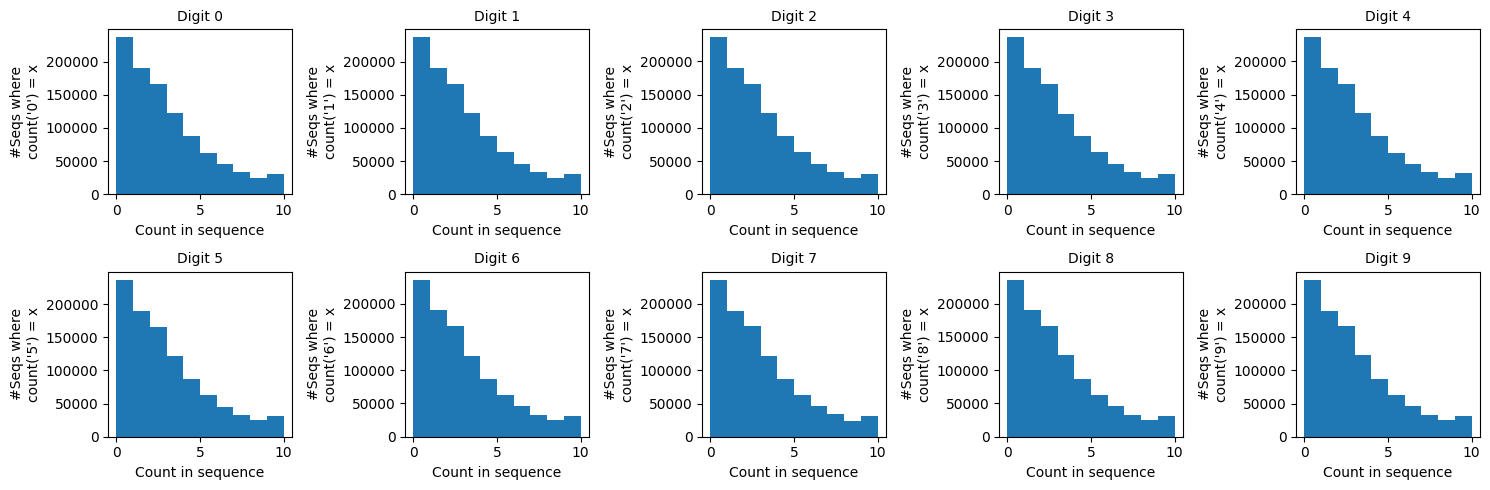

In [34]:
fig = plt.figure(figsize=(15, 5))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.hist(Z[str(i)], bins=10)
    ax.set_title(f"Digit {i}", fontsize=10)
    ax.set_xlabel("Count in sequence")
    ax.set_ylabel(f"#Seqs where\ncount('{i}') = x")
fig.tight_layout()
plt.show()

100%|██████████| 1000000/1000000 [00:01<00:00, 911447.18it/s]


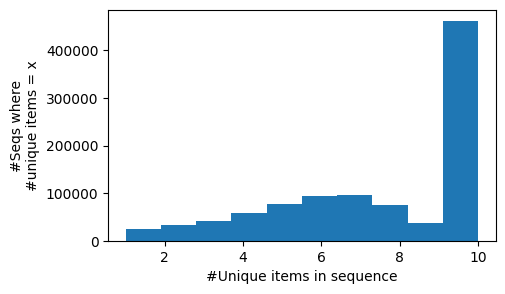

In [54]:
# histogram of #unique items
uniques = []
for x in tqdm(train_data):
    seq = x[0]
    uniques.append(len(set(seq))-1)
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)
ax.hist(uniques, bins=10)
ax.set_ylabel("#Seqs where\n#unique items = x")
ax.set_xlabel("#Unique items in sequence")
plt.show()

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:06<00:00,  5.98it/s]


1000000 2000


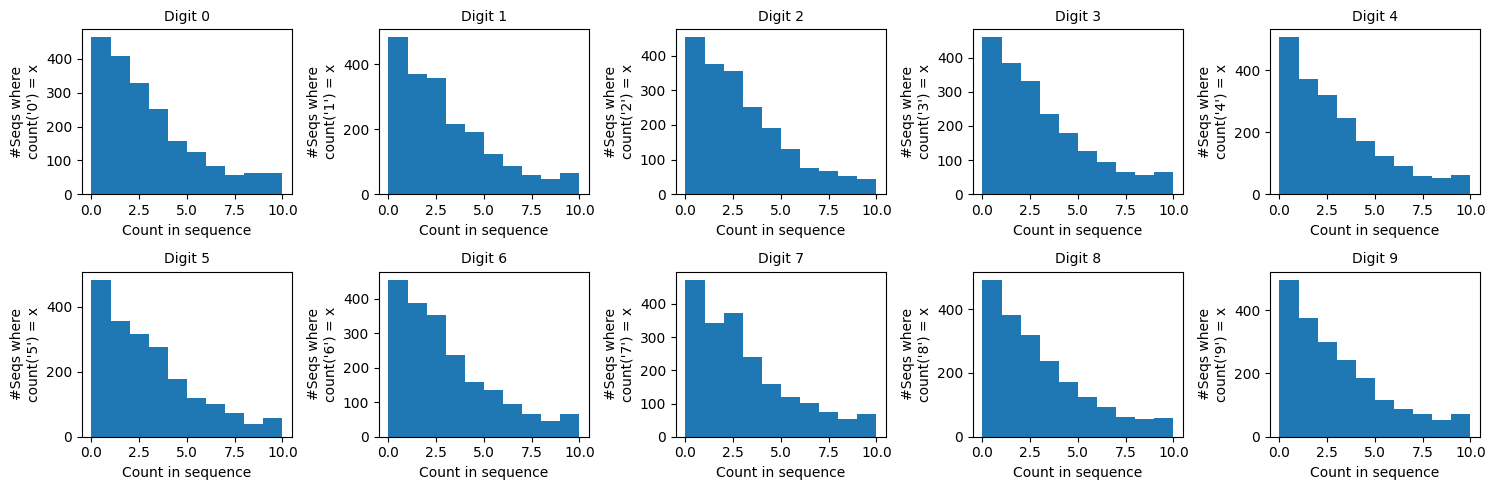

In [36]:
#create val set
val_data = []
Zv = defaultdict(list)
for cyc in trange(num_val//len(list(count_range))):
    for seq_len in count_range:
        while True:
            boundaries = [0] + sorted(random.sample(range(1, seq_len+10), 9)) + [seq_len+10]
            seq = []
            max_count = max([boundaries[i+1] - boundaries[i] - 1 for i in range(10)])
            if max_count > 10: continue
            min_count = min([boundaries[i+1] - boundaries[i] - 1 for i in range(10)])
            if seq_len > 20 and random.random() < min_count_drop_prop[min_count]: continue
            for d, i in zip("0123456789", range(10)):
                seq.extend([d] * (boundaries[i+1] - boundaries[i] - 1))
            random.shuffle(seq)
            x, y = [], []
            for i, tok in zip(range(len(seq)), seq):
                x.extend([tok, helper_tok])
            for i in range(len(seq)):
                y.extend(['-1', str(Counter(seq[:i])[seq[i]])])
            val_data.append([x, y])
            c = Counter(seq)
            for d in "0123456789":
                Zv[d].append(c[d])
            break
print(len(train_data), len(val_data))
fig = plt.figure(figsize=(15, 5))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.hist(Zv[str(i)], bins=10)
    ax.set_title(f"Digit {i}", fontsize=10)
    ax.set_xlabel("Count in sequence")
    ax.set_ylabel(f"#Seqs where\ncount('{i}') = x")
fig.tight_layout()
plt.show()

In [37]:
print(task)
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

selective_10items_padhelper
['-1', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '<pad>']


In [38]:
os.makedirs(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}", exist_ok=True)
os.makedirs(f"../data/rasp_primitives/counting_{task}", exist_ok=True)
with open(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
with open(f"../data/rasp_primitives/counting_{task}/val.txt", "w") as f:
    for x in val_data:
        f.write(json.dumps(x) + "\n")

In [49]:
min_count_drop_prop = [0.99, 0.5, 0.2, 0, 0, 0, 0, 0, 0, 0]
ood_data = []
Zt = defaultdict(list)
for cyc in trange(num_ood_test//len(list(count_range_ood))):
    for seq_len in count_range_ood:
        while True:
            boundaries = [0] + sorted(random.sample(range(1, 100-seq_len+10), 9)) + [100-seq_len+10]
            seq = []
            max_count = max([boundaries[i+1] - boundaries[i] - 1 for i in range(10)])
            if max_count > 10: continue
            min_count = min([boundaries[i+1] - boundaries[i] - 1 for i in range(10)])
            if random.random() < min_count_drop_prop[min_count]: continue
            for d, i in zip("0123456789", range(10)):
                seq.extend([d] * (10 - (boundaries[i+1] - boundaries[i] - 1)))
            random.shuffle(seq)
            x, y = [], []
            for i, tok in zip(range(len(seq)), seq):
                x.extend([tok, helper_tok])
            for i in range(len(seq)):
                y.extend(['-1', str(Counter(seq[:i])[seq[i]])])
            ood_data.append([x, y])
            c = Counter(seq)
            for d in "0123456789":
                Zt[d].append(c[d])
            break


  0%|          | 0/61 [00:00<?, ?it/s]

100%|██████████| 61/61 [00:01<00:00, 32.16it/s]


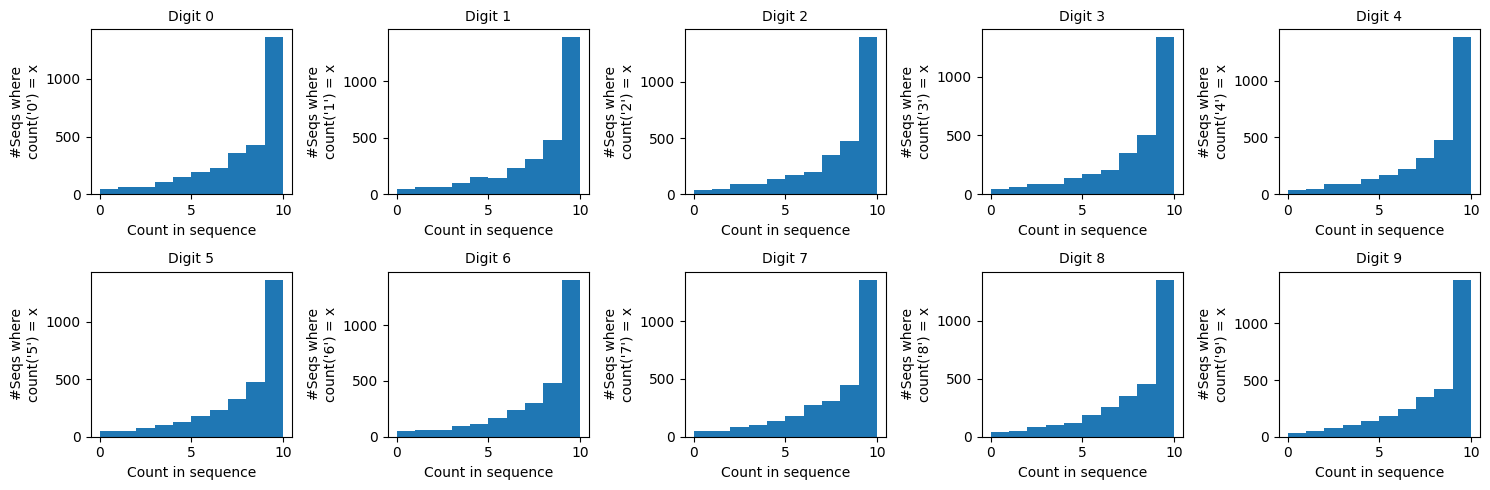

In [50]:
fig = plt.figure(figsize=(15, 5))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.hist(Zt[str(i)], bins=10)
    ax.set_title(f"Digit {i}", fontsize=10)
    ax.set_xlabel("Count in sequence")
    ax.set_ylabel(f"#Seqs where\ncount('{i}') = x")
fig.tight_layout()
plt.show()

In [51]:
print(task)
# Verify no ood counts
print(sorted(list(set([w for x in ood_data for w in x[0]] + [w for x in ood_data for w in x[1]]))))
with open(f"../data/rasp_primitives/counting_{task}/ood_test.txt", "w") as f:
    for x in ood_data:
        f.write(json.dumps(x) + "\n")

selective_10items_padhelper
['-1', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '<pad>']


100%|██████████| 2989/2989 [00:00<00:00, 531557.12it/s]


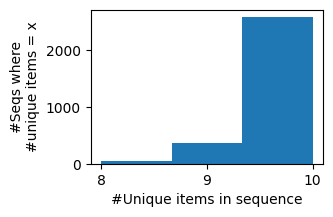

In [59]:
# histogram of #unique items
uniques = []
for x in tqdm(ood_data):
    seq = x[0]
    uniques.append(len(set(seq))-1)
fig = plt.figure(figsize=(3, 2))
ax = fig.add_subplot(111)
ax.hist(uniques, bins=len(set(uniques)))
ax.set_xticks(sorted(list(set(uniques))))
ax.set_ylabel("#Seqs where\n#unique items = x")
ax.set_xlabel("#Unique items in sequence")
plt.show()

## Selective Counting 10 Items (2)

In [15]:
import multiprocessing as mp
from joblib import Parallel, delayed
import shutil
ncpu = mp.cpu_count()

count_range = range(1, 51)
count_range_ood = range(51, 100)
num_train = 1000000
num_val = 2000
num_ood_test = 3000


In [16]:
# create training set
os.makedirs("tmp", exist_ok=True)
def job(cpu_id):
    f = open(f"tmp/{cpu_id}_train.txt", "w")
    seq_len = list(count_range)[-1]
    for cyc in range(num_train//ncpu + int(cpu_id < num_train%ncpu)):
        while True:
            boundaries = [0] + sorted(random.sample(range(1, seq_len+10), 9)) + [seq_len+10]
            seq = []
            max_count = max([boundaries[i+1] - boundaries[i] - 1 for i in range(10)])
            if max_count > 10: continue
            for d, i in zip("0123456789", range(10)):
                seq.extend([d] * (boundaries[i+1] - boundaries[i] - 1))
            random.shuffle(seq)
            f.write(json.dumps([seq, [str(Counter(seq[:i])[seq[i]]) for i in range(len(seq))]]) + "\n")
            break
    f.close()
    print("finish ", cpu_id)

confirms = Parallel(n_jobs = ncpu, backend="multiprocessing")(delayed(job)(cpu_id) for cpu_id in range(ncpu))

train_data = []
Z = defaultdict(list)
for cpu_id in range(ncpu):
    with open(f"tmp/{cpu_id}_train.txt", "r") as f:
        lines = f.readlines()
        train_data.extend([json.loads(l) for l in lines])
print(len(train_data))
for x in tqdm(train_data):
    seq = x[0]
    c = Counter("".join(seq))
    for d in "0123456789":
        Z[d].append(c[d])
shutil.rmtree("tmp")

finish finish  46
 3
finish  0
finish  4
finish  6
finish  2
finish  9
finish  8
finish  5
finish  7
finish  11
finish  1
finish  12
finish  19
finish  18
finish  25
finish  14
finish  13
finish  26
finish  16
finish finish   2017finish 

 23
finish finish  24 
42
finish  41
finish  22
finish finish finish    103821


finish  39
finish finish   3740

finish  32
finish finish finish    343631


finish finish finish finish finish finish  finish      2729 35331530
28





finish finish finish    474543


finish  44
1000000


100%|██████████| 1000000/1000000 [00:04<00:00, 249540.70it/s]


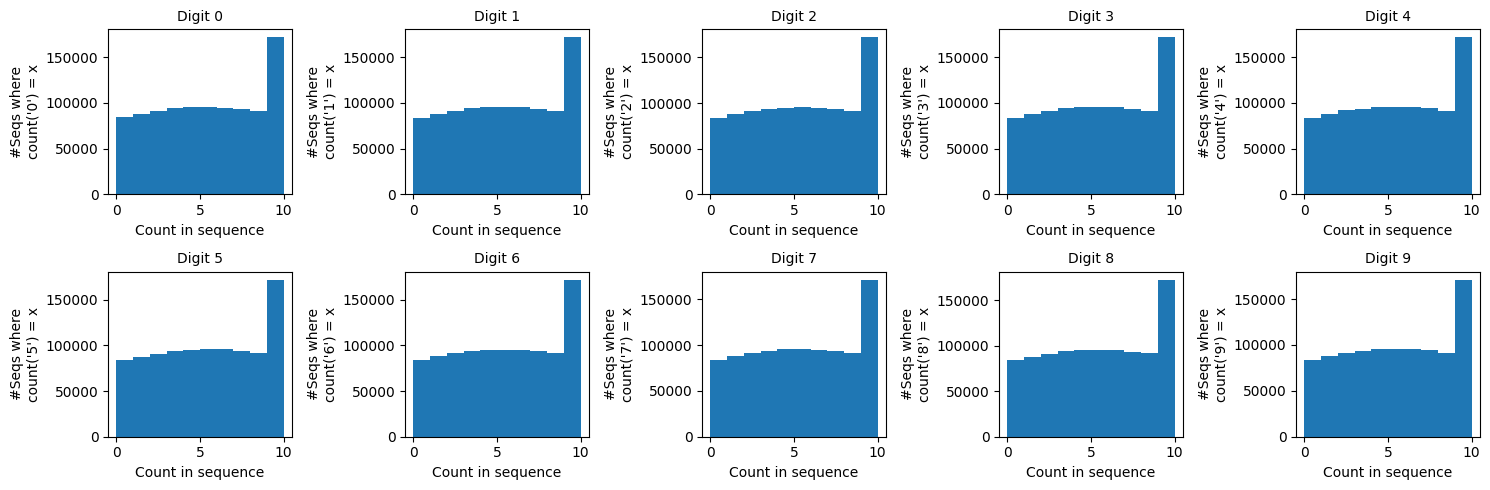

In [17]:
fig = plt.figure(figsize=(15, 5))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.hist(Z[str(i)], bins=10)
    ax.set_title(f"Digit {i}", fontsize=10)
    ax.set_xlabel("Count in sequence")
    ax.set_ylabel(f"#Seqs where\ncount('{i}') = x")
fig.tight_layout()
plt.show()

100%|██████████| 2000/2000 [00:00<00:00, 5480.24it/s]


1000000 2000


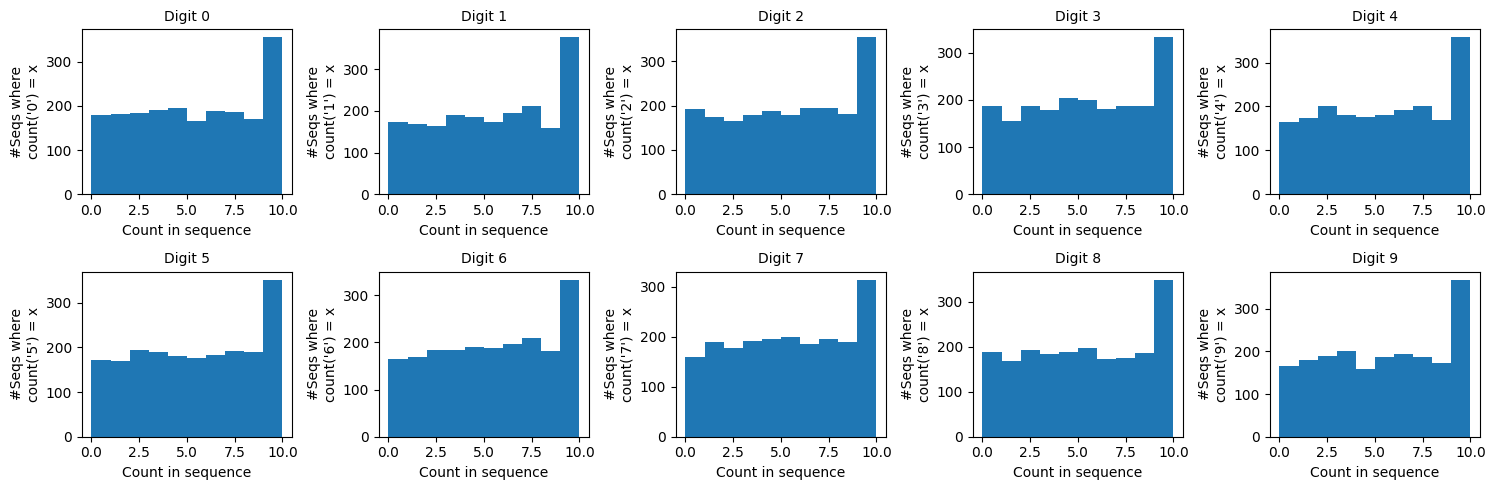

In [19]:
#create val set
val_data = []
Zv = defaultdict(list)
for cyc in trange(num_val):
    seq_len = list(count_range)[-1]
    while True:
        boundaries = [0] + sorted(random.sample(range(1, seq_len+10), 9)) + [seq_len+10]
        seq = []
        max_count = max([boundaries[i+1] - boundaries[i] - 1 for i in range(10)])
        if max_count > 10: continue
        for d, i in zip("0123456789", range(10)):
            seq.extend([d] * (boundaries[i+1] - boundaries[i] - 1))
        random.shuffle(seq)
        val_data.append([seq, [str(Counter(seq[:i])[seq[i]]) for i in range(len(seq))]])
        c = Counter(seq)
        for d in "0123456789":
            Zv[d].append(c[d])
        break
print(len(train_data), len(val_data))
fig = plt.figure(figsize=(15, 5))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.hist(Zv[str(i)], bins=10)
    ax.set_title(f"Digit {i}", fontsize=10)
    ax.set_xlabel("Count in sequence")
    ax.set_ylabel(f"#Seqs where\ncount('{i}') = x")
fig.tight_layout()
plt.show()

In [24]:
print(task)
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

selective_10items2
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [28]:
os.makedirs(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}", exist_ok=True)
os.makedirs(f"../data/rasp_primitives/counting_{task}", exist_ok=True)
with open(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
with open(f"../data/rasp_primitives/counting_{task}/val.txt", "w") as f:
    for x in val_data:
        f.write(json.dumps(x) + "\n")

100%|██████████| 61/61 [00:00<00:00, 105.40it/s]


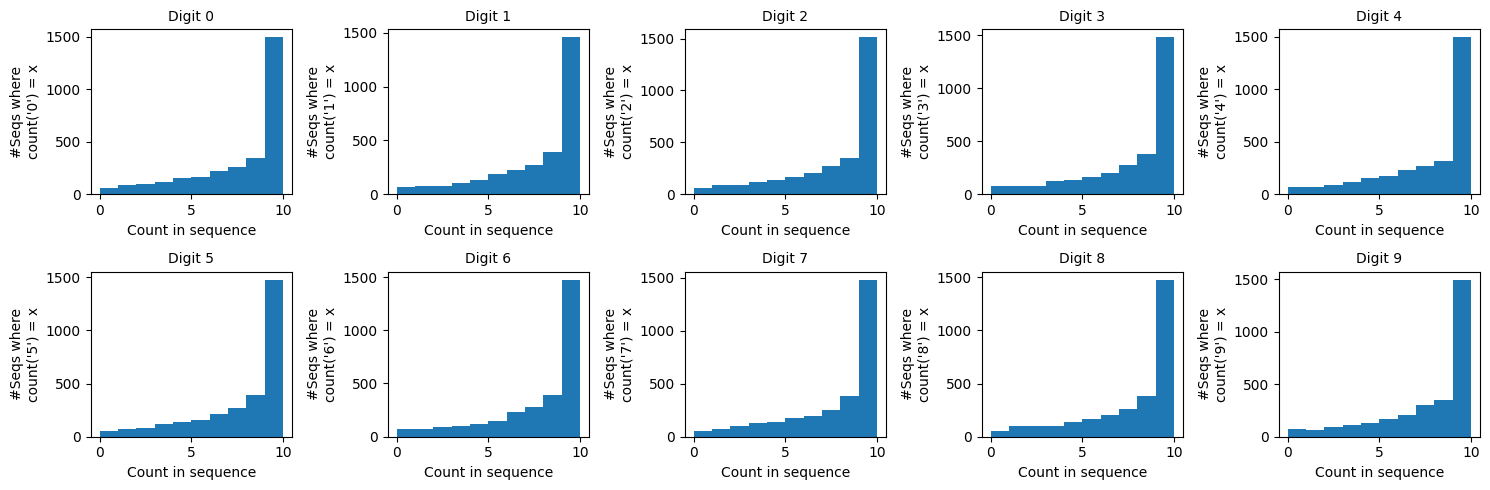

100%|██████████| 2989/2989 [00:00<00:00, 891916.24it/s]


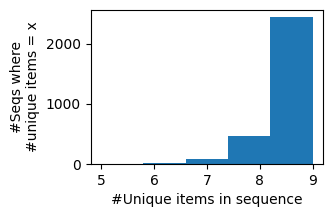

In [32]:
ood_data = []
Zt = defaultdict(list)
for cyc in trange(num_ood_test//len(list(count_range_ood))):
    for seq_len in count_range_ood:
        while True:
            boundaries = [0] + sorted(random.sample(range(1, 100-seq_len+10), 9)) + [100-seq_len+10]
            seq = []
            max_count = max([boundaries[i+1] - boundaries[i] - 1 for i in range(10)])
            if max_count > 10: continue
            for d, i in zip("0123456789", range(10)):
                seq.extend([d] * (10 - (boundaries[i+1] - boundaries[i] - 1)))
            random.shuffle(seq)
            ood_data.append([seq, [str(Counter(seq[:i])[seq[i]]) for i in range(len(seq))]])
            c = Counter(seq)
            for d in "0123456789":
                Zt[d].append(c[d])
            break

fig = plt.figure(figsize=(15, 5))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.hist(Zt[str(i)], bins=10)
    ax.set_title(f"Digit {i}", fontsize=10)
    ax.set_xlabel("Count in sequence")
    ax.set_ylabel(f"#Seqs where\ncount('{i}') = x")
fig.tight_layout()
plt.show()
# histogram of #unique items
uniques = []
for x in tqdm(ood_data):
    seq = x[0]
    uniques.append(len(set(seq))-1)
fig = plt.figure(figsize=(3, 2))
ax = fig.add_subplot(111)
ax.hist(uniques, bins=len(set(uniques)))
ax.set_xticks(sorted(list(set(uniques))))
ax.set_ylabel("#Seqs where\n#unique items = x")
ax.set_xlabel("#Unique items in sequence")
plt.show()

In [34]:
print(task)
# Verify no ood counts
print(sorted(list(set([w for x in ood_data for w in x[0]] + [w for x in ood_data for w in x[1]]))))
with open(f"../data/rasp_primitives/counting_{task}/ood_test.txt", "w") as f:
    for x in ood_data:
        f.write(json.dumps(x) + "\n")

selective_10items2
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## Selective Counting 10 Items + PadHelper (2)

In [3]:
import multiprocessing as mp
from joblib import Parallel, delayed
import shutil
ncpu = mp.cpu_count()

In [7]:
count_range = range(1, 51)
count_range_ood = range(51, 100)
num_train = 1000000
num_val = 2000
num_ood_test = 3000

if "blankhelper" in task:
    helper_tok = '<blk>'
elif "padhelper" in task:
    helper_tok = '<pad>'
else:
    pass

  0%|          | 0/1000000 [00:00<?, ?it/s]

100%|██████████| 1000000/1000000 [03:25<00:00, 4862.92it/s]


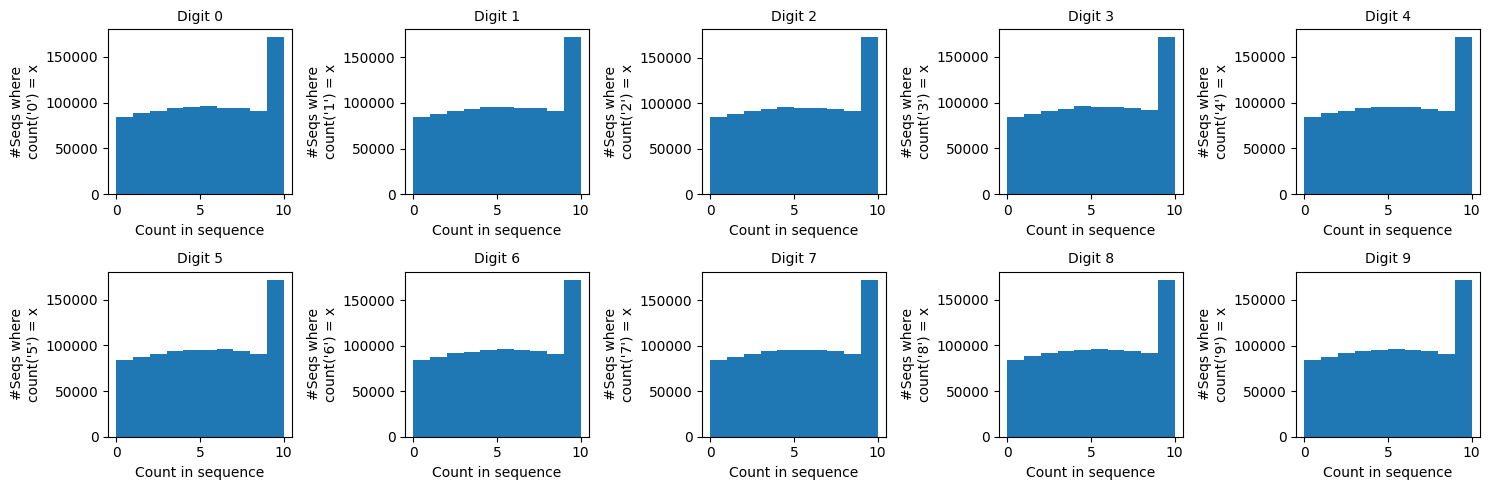

In [8]:
# create training set
train_data = []
Z = defaultdict(list)
for cyc in trange(num_train):
    seq_len = list(count_range)[-1]
    while True:
        boundaries = [0] + sorted(random.sample(range(1, seq_len+10), 9)) + [seq_len+10]
        seq = []
        max_count = max([boundaries[i+1] - boundaries[i] - 1 for i in range(10)])
        if max_count > 10: continue
        for d, i in zip("0123456789", range(10)):
            seq.extend([d] * (boundaries[i+1] - boundaries[i] - 1))
        random.shuffle(seq)
        x, y = [], []
        for i, tok in zip(range(len(seq)), seq):
            x.extend([tok, helper_tok])
        for i in range(len(seq)):
            y.extend(['-1', str(Counter(seq[:i])[seq[i]])])
        train_data.append([x, y])
        c = Counter(seq)
        for d in "0123456789":
            Z[d].append(c[d])
        break

fig = plt.figure(figsize=(15, 5))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.hist(Z[str(i)], bins=10)
    ax.set_title(f"Digit {i}", fontsize=10)
    ax.set_xlabel("Count in sequence")
    ax.set_ylabel(f"#Seqs where\ncount('{i}') = x")
fig.tight_layout()
plt.show()

100%|██████████| 2000/2000 [00:00<00:00, 4881.98it/s]


1000000 2000


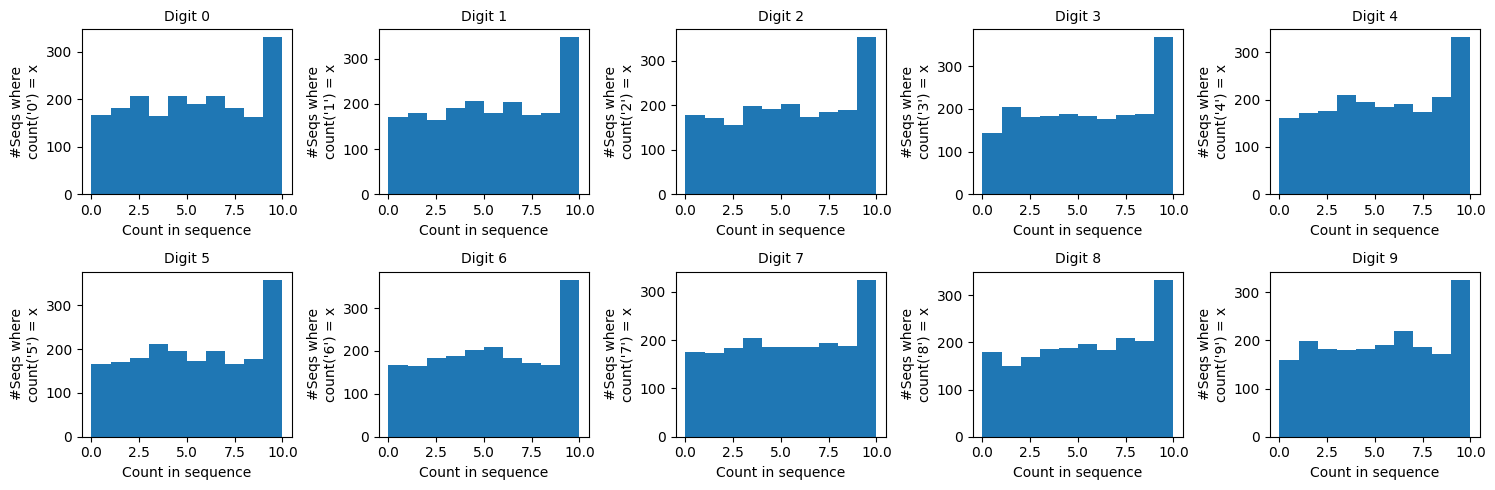

In [9]:
#create val set
val_data = []
Zv = defaultdict(list)
for cyc in trange(num_val):
    seq_len = list(count_range)[-1]
    while True:
        boundaries = [0] + sorted(random.sample(range(1, seq_len+10), 9)) + [seq_len+10]
        seq = []
        max_count = max([boundaries[i+1] - boundaries[i] - 1 for i in range(10)])
        if max_count > 10: continue
        for d, i in zip("0123456789", range(10)):
            seq.extend([d] * (boundaries[i+1] - boundaries[i] - 1))
        random.shuffle(seq)
        x, y = [], []
        for i, tok in zip(range(len(seq)), seq):
            x.extend([tok, helper_tok])
        for i in range(len(seq)):
            y.extend(['-1', str(Counter(seq[:i])[seq[i]])])
        val_data.append([x, y])
        c = Counter(seq)
        for d in "0123456789":
            Zv[d].append(c[d])
        break
print(len(train_data), len(val_data))
fig = plt.figure(figsize=(15, 5))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.hist(Zv[str(i)], bins=10)
    ax.set_title(f"Digit {i}", fontsize=10)
    ax.set_xlabel("Count in sequence")
    ax.set_ylabel(f"#Seqs where\ncount('{i}') = x")
fig.tight_layout()
plt.show()

In [10]:
print(task)
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

selective_10items_padhelper2
['-1', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '<pad>']


In [11]:
os.makedirs(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}", exist_ok=True)
os.makedirs(f"../data/rasp_primitives/counting_{task}", exist_ok=True)
with open(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
with open(f"../data/rasp_primitives/counting_{task}/val.txt", "w") as f:
    for x in val_data:
        f.write(json.dumps(x) + "\n")

In [12]:
ood_data = []
Zt = defaultdict(list)
for cyc in trange(num_ood_test//len(list(count_range_ood))):
    for seq_len in count_range_ood:
        while True:
            boundaries = [0] + sorted(random.sample(range(1, 100-seq_len+10), 9)) + [100-seq_len+10]
            seq = []
            max_count = max([boundaries[i+1] - boundaries[i] - 1 for i in range(10)])
            if max_count > 10: continue
            for d, i in zip("0123456789", range(10)):
                seq.extend([d] * (10 - (boundaries[i+1] - boundaries[i] - 1)))
            random.shuffle(seq)
            x, y = [], []
            for i, tok in zip(range(len(seq)), seq):
                x.extend([tok, helper_tok])
            for i in range(len(seq)):
                y.extend(['-1', str(Counter(seq[:i])[seq[i]])])
            ood_data.append([x, y])
            c = Counter(seq)
            for d in "0123456789":
                Zt[d].append(c[d])
            break


100%|██████████| 61/61 [00:00<00:00, 94.14it/s]


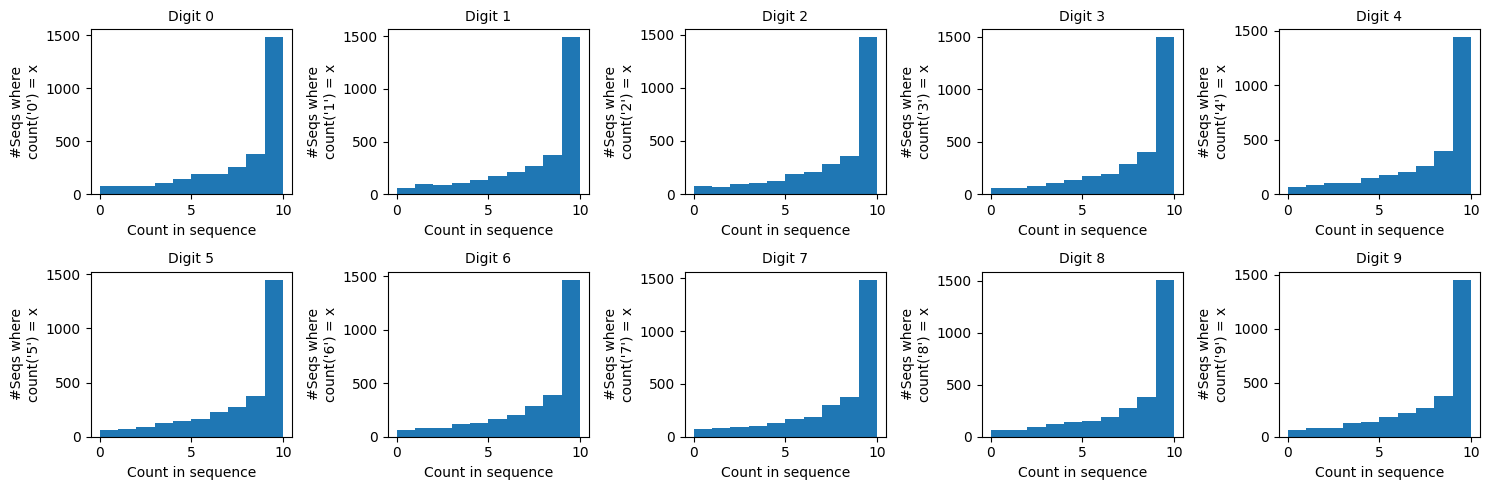

100%|██████████| 2989/2989 [00:00<00:00, 725339.89it/s]


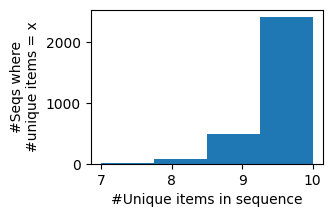

In [13]:
fig = plt.figure(figsize=(15, 5))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.hist(Zt[str(i)], bins=10)
    ax.set_title(f"Digit {i}", fontsize=10)
    ax.set_xlabel("Count in sequence")
    ax.set_ylabel(f"#Seqs where\ncount('{i}') = x")
fig.tight_layout()
plt.show()
# histogram of #unique items
uniques = []
for x in tqdm(ood_data):
    seq = x[0]
    uniques.append(len(set(seq))-1)
fig = plt.figure(figsize=(3, 2))
ax = fig.add_subplot(111)
ax.hist(uniques, bins=len(set(uniques)))
ax.set_xticks(sorted(list(set(uniques))))
ax.set_ylabel("#Seqs where\n#unique items = x")
ax.set_xlabel("#Unique items in sequence")
plt.show()

In [14]:
print(task)
# Verify no ood counts
print(sorted(list(set([w for x in ood_data for w in x[0]] + [w for x in ood_data for w in x[1]]))))
with open(f"../data/rasp_primitives/counting_{task}/ood_test.txt", "w") as f:
    for x in ood_data:
        f.write(json.dumps(x) + "\n")

selective_10items_padhelper2
['-1', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '<pad>']


## Selective Modular Counting

In [3]:
import multiprocessing as mp
from joblib import Parallel, delayed
import shutil
ncpu = mp.cpu_count()

count_range = range(1, 65)
count_range_ood = range(65, 129)
num_train = 1000000
num_val = 2000
num_ood_test = 3000


In [4]:
# create training set
os.makedirs("tmp", exist_ok=True)
num_items = 4
def job(cpu_id):
    f = open(f"tmp/{cpu_id}_train.txt", "w")
    seq_len = list(count_range)[-1]
    for cyc in range(num_train//ncpu + int(cpu_id < num_train%ncpu)):
        while True:
            boundaries = [0] + sorted(random.sample(range(1, seq_len+num_items), num_items-1)) + [seq_len+num_items]
            seq = []
            max_count = max([boundaries[i+1] - boundaries[i] - 1 for i in range(num_items)])
            if max_count > 64: continue
            #min_count = max([boundaries[i+1] - boundaries[i] - 1 for i in range(num_items)])
            #if min_count < 8: 
            #    if random.random < 0.999 - min_count/8: continue
            for d, i in zip("0123", range(num_items)):
                seq.extend([d] * (boundaries[i+1] - boundaries[i] - 1))
            random.shuffle(seq)
            f.write(json.dumps([seq, [str(Counter(seq[:i])[seq[i]]%num_items) for i in range(len(seq))]]) + "\n")
            break
    f.close()
    print("finish ", cpu_id)

confirms = Parallel(n_jobs = ncpu, backend="multiprocessing")(delayed(job)(cpu_id) for cpu_id in range(ncpu))

train_data = []
Z = defaultdict(list)
for cpu_id in range(ncpu):
    with open(f"tmp/{cpu_id}_train.txt", "r") as f:
        lines = f.readlines()
        train_data.extend([json.loads(l) for l in lines])
print(len(train_data))
for x in tqdm(train_data):
    seq = x[0]
    c = Counter("".join(seq))
    for d in "0123":
        Z[d].append(c[d])
shutil.rmtree("tmp")

finish  13
finish  26
finish  14
finish  0
finish  44
finish  19
finish  24
finish  16
finish  23
finish  5
finish  1
finish  2
finish  15
finish  8
finish  4
finish  7
finish  10
finish  17
finish  18
finish  27
finish  3
finish  6
finish  12
finish  34
finish finish finish    411143


finish finish   4740

finish finish finish finish finish finish finish finish finish  finish finish finish finish finish finish finish finish         45       32 33462537362035
302838294239
31
9













finish  22
finish  21
1000000


100%|██████████| 1000000/1000000 [00:03<00:00, 295773.52it/s]


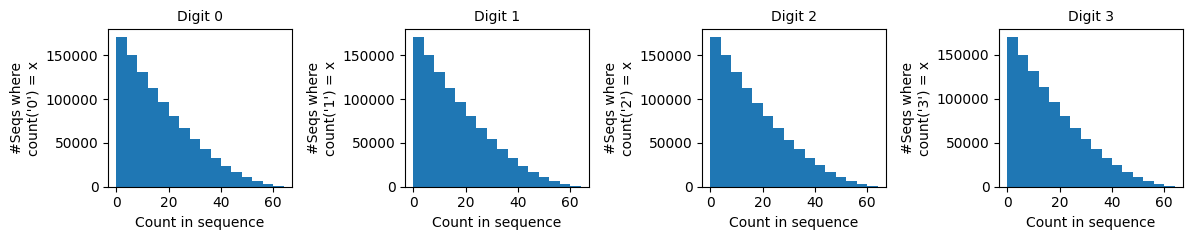

In [5]:
rows = num_items//5+int(num_items%5>0)
fig = plt.figure(figsize=(15, 2.5*rows))

for i in range(num_items):
    ax = fig.add_subplot(rows, 5, i+1)
    ax.hist(Z[str(i)], bins=16)
    ax.set_title(f"Digit {i}", fontsize=10)
    ax.set_xlabel("Count in sequence")
    ax.set_ylabel(f"#Seqs where\ncount('{i}') = x")
fig.tight_layout()
plt.show()

 34%|███▍      | 690/2000 [00:00<00:00, 6891.36it/s]

100%|██████████| 2000/2000 [00:00<00:00, 6873.89it/s]


1000000 2000


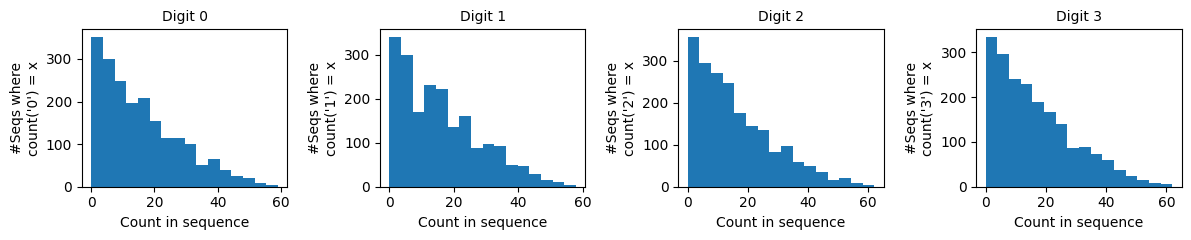

In [6]:
#create val set
val_data = []
Zv = defaultdict(list)
for cyc in trange(num_val):
    seq_len = list(count_range)[-1]
    while True:
        boundaries = [0] + sorted(random.sample(range(1, seq_len+num_items), num_items-1)) + [seq_len+num_items]
        seq = []
        max_count = max([boundaries[i+1] - boundaries[i] - 1 for i in range(num_items)])
        if max_count > 64: continue
        for d, i in zip("0123", range(num_items)):
            seq.extend([d] * (boundaries[i+1] - boundaries[i] - 1))
        random.shuffle(seq)
        val_data.append([seq, [str(Counter(seq[:i])[seq[i]]%num_items) for i in range(len(seq))]])
        c = Counter(seq)
        for d in "0123":
            Zv[d].append(c[d])
        break
print(len(train_data), len(val_data))
rows = num_items//5+int(num_items%5>0)
fig = plt.figure(figsize=(15, 2.5*rows))
for i in range(num_items):
    ax = fig.add_subplot(rows, 5, i+1)
    ax.hist(Zv[str(i)], bins=16)
    ax.set_title(f"Digit {i}", fontsize=10)
    ax.set_xlabel("Count in sequence")
    ax.set_ylabel(f"#Seqs where\ncount('{i}') = x")
fig.tight_layout()
plt.show()

In [7]:
print(task)
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

selective_modular_4items
['0', '1', '2', '3']


In [8]:
os.makedirs(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}", exist_ok=True)
os.makedirs(f"../data/rasp_primitives/counting_{task}", exist_ok=True)
with open(f"/data/yingshac/llms_do_math/data/rasp_primitives/counting_{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
with open(f"../data/rasp_primitives/counting_{task}/val.txt", "w") as f:
    for x in val_data:
        f.write(json.dumps(x) + "\n")

 70%|██████▉   | 2092/3000 [00:00<00:00, 2642.54it/s]

100%|██████████| 3000/3000 [00:01<00:00, 2623.00it/s]


3000


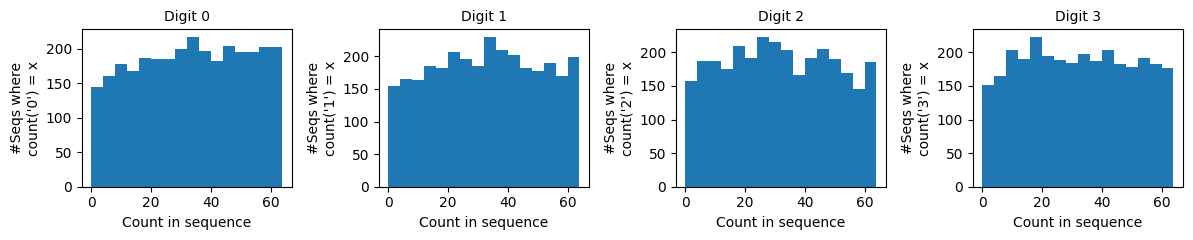

In [9]:
ood_data = []
Zt = defaultdict(list)
for cyc in trange(num_ood_test):
    seq_len = list(count_range_ood)[-1]
    while True:
        boundaries = [0] + sorted(random.sample(range(1, seq_len+num_items), num_items-1)) + [seq_len+num_items]
        seq = []
        max_count = max([boundaries[i+1] - boundaries[i] - 1 for i in range(num_items)])
        if max_count > 64: continue
        for d, i in zip("0123", range(num_items)):
            seq.extend([d] * (boundaries[i+1] - boundaries[i] - 1))
        random.shuffle(seq)
        ood_data.append([seq, [str(Counter(seq[:i])[seq[i]]%num_items) for i in range(len(seq))]])
        c = Counter(seq)
        for d in "0123":
            Zt[d].append(c[d])
        break
print(len(ood_data))
rows = num_items//5+int(num_items%5>0)
fig = plt.figure(figsize=(15, 2.5*rows))
for i in range(num_items):
    ax = fig.add_subplot(rows, 5, i+1)
    ax.hist(Zt[str(i)], bins=16)
    ax.set_title(f"Digit {i}", fontsize=10)
    ax.set_xlabel("Count in sequence")
    ax.set_ylabel(f"#Seqs where\ncount('{i}') = x")
fig.tight_layout()
plt.show()

In [10]:
with open(f"../data/rasp_primitives/counting_{task}/ood_test.txt", "w") as f:
    for x in ood_data:
        f.write(json.dumps(x) + "\n")

## Addtable

In [29]:
priming_ratio = 0.5
num_train = 1000000
count_range = range(1, 51)
count_range_ood = range(51, 101)

In [30]:
max_sum = list(count_range_ood)[-1]

# create val set
val_data = []
for x1 in range(1, max_sum):
    for x2 in range(1, max_sum-x1+1):
        val_data.append(([str(x1), str(x2)], [str(x1), str(x1+x2)]))

# create training set
train_data = []
for cycle in range(int(num_train * priming_ratio) // len(val_data)):
    for x1 in range(1, max_sum):
        for x2 in range(1, max_sum-x1+1):
            train_data.append(([str(x1), str(x2)], [str(x1), str(x1+x2)]))

print(len(train_data), len(val_data))

499950 4950


In [31]:
print(task)
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

addtable_large
['1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


In [32]:
os.makedirs(f"/data/yingshac/llms_do_math/data/rasp_primitives/{task}", exist_ok=True)
os.makedirs(f"../data/rasp_primitives/{task}", exist_ok=True)
with open(f"/data/yingshac/llms_do_math/data/rasp_primitives/{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
with open(f"../data/rasp_primitives/{task}/{task}_test.txt", "w") as f:
    for x in val_data:
        f.write(json.dumps(x) + "\n")

## Addtable + Pad Helper

In [34]:
if "blankhelper" in task:
    helper_tok = '<blk>'
elif "padhelper" in task:
    helper_tok = '<pad>'
else:
    pass

In [35]:
priming_ratio = 0.5
num_train = 1000000
count_range = range(1, 51)
count_range_ood = range(51, 101)

In [36]:
max_sum = list(count_range_ood)[-1]

# create val set
val_data = []
for x1 in range(1, max_sum):
    for x2 in range(1, max_sum-x1+1):
        val_data.append(([str(x1), helper_tok, str(x2), helper_tok], ["-1", str(x1), "-1", str(x1+x2)]))

# create training set
train_data = []
for cycle in range(int(num_train * priming_ratio) // len(val_data)):
    for x1 in range(1, max_sum):
        for x2 in range(1, max_sum-x1+1):
            train_data.append(([str(x1), helper_tok, str(x2), helper_tok], ["-1", str(x1), "-1", str(x1+x2)]))

print(len(train_data), len(val_data))

499950 4950


In [37]:
print(task)
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

addtable_padhelper_large
['-1', '1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '<pad>']


In [38]:
os.makedirs(f"/data/yingshac/llms_do_math/data/rasp_primitives/{task}", exist_ok=True)
os.makedirs(f"../data/rasp_primitives/{task}", exist_ok=True)
with open(f"/data/yingshac/llms_do_math/data/rasp_primitives/{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
#with open(f"../data/rasp_primitives/{task}/{task}_test.txt", "w") as f:
#    for x in val_data:
#        f.write(json.dumps(x) + "\n")

## Bigram

In [4]:
count_range_ood = range(51, 201)
priming_ratio = 0.1
num_val = 10
num_train = 1000000

In [5]:
max_sum = list(count_range_ood)[-1]
train_data = []
for i in range(int(num_train * priming_ratio)):
    seq = [str(x) for x in range(1, max_sum+1)]
    train_data.append([seq[:-1], seq[1:]])
val_data = train_data[:num_val]
print(len(train_data), len(val_data))

100000 10


In [6]:
print(task)
# Verify vocab
print(sorted(list(set([w for x in train_data for w in x[0]] + [w for x in train_data for w in x[1]]))))

addbigram_upto200
['1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '18', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '19', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '2', '20', '200', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51

In [9]:
os.makedirs(f"/data/yingshac/llms_do_math/data/rasp_primitives/{task}", exist_ok=True)
os.makedirs(f"../data/rasp_primitives/{task}", exist_ok=True)
with open(f"/data/yingshac/llms_do_math/data/rasp_primitives/{task}/train.txt", "w") as f:
    for x in train_data:
        f.write(json.dumps(x) + "\n")
with open(f"../data/rasp_primitives/{task}/{task}_test.txt", "w") as f:
    for x in val_data:
        f.write(json.dumps(x) + "\n")

## Draft